# Skeleton Threat Detection

In [1]:
import time
import numpy as np
import tensorflow as tf
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

# Part 1: Load Data

In [2]:
# set relevant skeletal indexes in the desired order with labels. Create array for skeletons with confidence flag
rele_dexes = [6,8,10,12,5,7,9,11,0,1,2,3,4,-1]
joint_names = ['R Shoulder','R Elbow','R Wrist','R Hip','L Shoulder','L Elbow','L Wrist','L Hip','Nose','L Eye','R Eye','L Ear','R Ear','Gun']
conf_flag = 1   # should be 0 or 1
x = np.empty((1,len(rele_dexes),2+conf_flag))
y = []

# set indexes for normalization 
right_elbow = 8
right_wrist = 10
l_shoulder = 5
r_shoulder = 6

#set folders and labels for each folder (0=high,1=medium,2=low)
folders = ["body_coco/skeleton_threat/1_high/skeletons/", "body_coco/skeleton_threat/2_medium/skeletons/", "body_coco/skeleton_threat/3_mild/skeletons/", "body_coco/skeleton_threat/4_low/skeletons/"]
threats = [0,1,2,2]

#read skeletons into array and create labels
last_count = 0
for folder in range(len(folders)):
    for f in listdir(folders[folder]):
        skele = np.load(folders[folder]+f)    #read skeletons
        skele[-1][-1] = 1  #reset gun confidence which is always 0 in given files
        if skele[rele_dexes].all() > .0001:     #only include skeletons with all joints
            skele[:,0:2] -= skele[right_elbow,0:2]     #normalize to right elbow with elbow to wrist=1
            forearm_len = np.sqrt(skele[right_wrist][0]**2+skele[right_wrist][1]**2)
            skele[:,0:2] /= forearm_len
            x = np.vstack((x,np.expand_dims(skele[rele_dexes,0:2+conf_flag],axis=0))) #add to input array
    y = np.concatenate((y,[threats[folder]]*(x.shape[0]-last_count)))   #add labels to label list
    last_count = x.shape[0]
                    
x_flat = x.reshape([x.shape[0],x.shape[1]*x.shape[2]]) #flatten for neural network input

#checks for sizes
print(x.shape)
print(y.shape)
print(x[-1])

(1471, 14, 3)
(1471,)
[[ 0.93254202  0.48161385  4.37526408]
 [ 0.          0.          5.4692235 ]
 [-0.78673816 -0.61728686  5.24052811]
 [ 1.14912533  3.6012014   2.63764807]
 [ 2.21164281  0.45873213  4.46244648]
 [ 2.44494012  2.42331951  4.92402482]
 [ 1.63649646  3.61879279  4.14439843]
 [ 2.26786108  3.6105473   2.91979881]
 [ 0.79884182 -0.25417694  5.91340017]
 [ 0.98039678 -0.55676854  6.06990862]
 [ 0.61728686 -0.4357319   6.10064983]
 [ 1.58557998 -0.7383235   5.49394369]
 [ 0.49625022 -0.4357319   0.03445279]
 [ 1.46756926  3.01078641  1.        ]]


In [3]:
# create one hot label array from labels
oh_y = np.array(y,dtype=np.int64)
num_labels = len(np.unique(oh_y))
oh_y = np.eye(num_labels)[oh_y]

# columns: x, y, confidence

# Create and Train Model

In [4]:
from feedforward_model import *

In [5]:
# set splits for k-folds and create empty array
splits = 10
kf = KFold(n_splits=splits, shuffle=True, random_state=4)
conf_mat = np.empty((splits,num_labels,num_labels))

# train models for each split and save to an array
i = 0
for train_index, test_index in kf.split(x_flat):
    x_train, x_test = x_flat[train_index], x_flat[test_index]   #create train and test sets
    y_train, y_test = oh_y[train_index], oh_y[test_index]
    
    # create and train model
    model = feedforward(x_flat.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
    model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64)
    conf_mat[i] = confusion_matrix(y[test_index],model.predict(x_test)[0])  #add confusion matrix to array
    i += 1

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

number of batches for training: 20
0.022455930709838867
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 33.78378378378378%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.2972972972973%
epoch 4
Best validation accuracy! iteration:75 accuracy: 52.702702702702695%
epoch 5
Best validation accuracy! iteration:100 accuracy: 57.432432432432435%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 60.13513513513513%
epoch 8
Best validation accuracy! iteration:150 accuracy: 62.16216216216216%
epoch 9
Best validation accuracy! iteration:175 accuracy: 66.21621621621621%
epoch 10

number of batches for training: 20
0.01928257942199707
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 37.41496598639456%
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 42.857142857142854%
epoch 8
Best validation accuracy! iteration:150 accuracy: 52.38095238095239%
epoch 9
Best validation accuracy! iteration:175 accuracy: 57.82312925170068%
epoch 10
Best validation accuracy! iteration:200 accuracy: 61.224489795918366%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 66.66666666666666%
epoch 13
Best validation accuracy! iteration:250 accuracy: 70.74829931972789%
epoch 14
Best validation accuracy! iteration:275 accuracy: 72.10884353741497%
epoch 15
Best validation accuracy! iteration:300 accuracy: 73.46938775510205%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 74.82993197278913%
epoch 20
Best validation accuracy! iteration:400 accuracy: 75.51020408163265%
epoch 21
epoch

[[649.  34.   9.]
 [ 59. 158. 108.]
 [  5.  34. 415.]]
mean
[[64.9  3.4  0.9]
 [ 5.9 15.8 10.8]
 [ 0.5  3.4 41.5]]
std
[[4.25323406 1.68522995 0.83066239]
 [1.13578167 2.35796522 3.57211422]
 [0.92195445 1.356466   4.5       ]]
83.0727396329028
0.450421992480692
6.6257075093909785


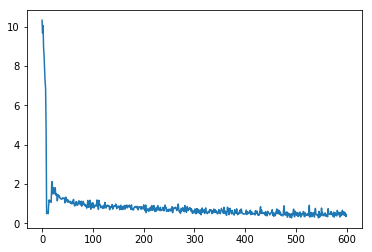

In [6]:
# plot loss, total classifications, mean over splits, and std over splits
model.plot()
print(sum(conf_mat))
print("mean")
print(np.mean(conf_mat,axis=0))
print("std")
print(np.std(conf_mat,axis=0))

#create accuracy (sum of diagonal dividied by total classified)
mat = sum(conf_mat)
diag = sum(np.diagonal(mat))
print(diag/sum(sum(mat))*100)

#find and print standard deviations
stds = np.std(conf_mat,axis=0)
var = 0
for i in range(conf_mat.shape[1]):
    var += stds[i,i]**2
print(np.sqrt(var)/sum(sum(mat))*100)
print(np.sqrt(var))

In [7]:
#give a prediction example
labels = np.array(['High','Med','Low'])
test = np.reshape(x_test[0],(1,len(x_test[0])))
prediction = model.predict(test)
print("Predicted label is ", labels[prediction[0][0]])
tested_y = np.ndarray.astype(y_test[0],bool)
print("Actual label is ",labels[tested_y][0])

INFO:tensorflow:Restoring parameters from model/basic_model
Predicted label is  High
Actual label is  High


In [8]:
# find and print mean and totals in LaTeX code
mean = np.mean(conf_mat,axis=0)
totals_b = np.sum(mean,axis=0)
totals_r = np.sum(mean,axis=1)
total = np.sum(totals_r)
print(end='\\rota{Actual}')
for i in range(mean.shape[0]):
    print(" & {0:s} & {1:.1f} & {2:.1f} & {3:.1f} & {4:.1f} \\\\".format(labels[i],mean[i,0],mean[i,1],mean[i,2],totals_r[i]))
print('\\toprule')
print(" & Totals & {0:.1f} & {1:.1f} & {2:.1f} & {3:.1f}".format(totals_b[0],totals_b[1],totals_b[2],total))

\rota{Actual} & High & 64.9 & 3.4 & 0.9 & 69.2 \\
 & Med & 5.9 & 15.8 & 10.8 & 32.5 \\
 & Low & 0.5 & 3.4 & 41.5 & 45.4 \\
\toprule
 & Totals & 71.3 & 22.6 & 53.2 & 147.1


In [9]:
#create new confusion matrix
conf_mat = np.empty((x.shape[1],splits,num_labels,num_labels))

#remove each joint from input and retrain with k-folds
for i in range(x.shape[1]):
    print(i)
    sub_x = np.delete(x,i,1)
    sub_x = sub_x.reshape([sub_x.shape[0],sub_x.shape[1]*sub_x.shape[2]])
    j = 0
    for train_index, test_index in kf.split(sub_x):
        x_train, x_test = sub_x[train_index], sub_x[test_index]
        y_train, y_test = oh_y[train_index], oh_y[test_index]
        model = feedforward(sub_x.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
        model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64)
        conf_mat[i,j] = confusion_matrix(y[test_index],model.predict(x_test)[0])
        j += 1

0
number of batches for training: 20
0.018603086471557617
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.24324324324324%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.35135135135135%
epoch 4
Best validation accuracy! iteration:75 accuracy: 57.432432432432435%
epoch 5
Best validation accuracy! iteration:100 accuracy: 62.83783783783784%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 66.21621621621621%
epoch 8
Best validation accuracy! iteration:150 accuracy: 68.24324324324324%
epoch 9
Best validation accuracy! iteration:175 accuracy: 69.5945945945946%
epoch 10
Best validation accuracy! iteration:200 accuracy: 70.27027027027027%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 72.97297297297297%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 75.0%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 75.67567567567568%
epoch 19
Best validation accuracy! iteration:3

number of batches for training: 20
0.01661992073059082
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.49659863945578%
epoch 3
Best validation accuracy! iteration:50 accuracy: 58.50340136054422%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.904761904761905%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.70748299319727%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 72.10884353741497%
epoch 8
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 74.82993197278913%
epoch 14
Best validation accuracy! iteration:275 accuracy: 75.51020408163265%
epoch 15
Best validation accuracy! iteration:300 accuracy: 76.19047619047619%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 76.87074829931973%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 78.2312925170068%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 78.91156462585033%


number of batches for training: 20
0.016824960708618164
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 23.12925170068027%
epoch 3
Best validation accuracy! iteration:50 accuracy: 49.65986394557823%
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.06122448979592%
epoch 5
Best validation accuracy! iteration:100 accuracy: 57.14285714285714%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 67.3469387755102%
epoch 8
Best validation accuracy! iteration:150 accuracy: 73.46938775510205%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.14965986394559%
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.19047619047619%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 77.55102040816327%
epoch 13
Best validation accuracy! iteration:250 accuracy: 80.27210884353741%
epoch 14
Best validation accuracy! iteration:275 accuracy: 80.95238095238095%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22


epoch 10
Best validation accuracy! iteration:200 accuracy: 40.136054421768705%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 40.816326530612244%
epoch 18
Best validation accuracy! iteration:350 accuracy: 45.57823129251701%
epoch 19
Best validation accuracy! iteration:375 accuracy: 49.65986394557823%
epoch 20
Best validation accuracy! iteration:400 accuracy: 55.10204081632652%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 58.50340136054422%
epoch 23
Best validation accuracy! iteration:450 accuracy: 68.02721088435374%
epoch 24
Best validation accuracy! iteration:475 accuracy: 68.70748299319727%
epoch 25
Best validation accuracy! iteration:500 accuracy: 70.74829931972789%
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 72.10884353741497%
epoch 28
Best validation accuracy! iteration:550 accuracy: 73.46938775510205%
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 

number of batches for training: 20
0.01656341552734375
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 34.69387755102041%
epoch 3
Best validation accuracy! iteration:50 accuracy: 38.095238095238095%
epoch 4
Best validation accuracy! iteration:75 accuracy: 51.70068027210885%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.224489795918366%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 73.46938775510205%
epoch 8
Best validation accuracy! iteration:150 accuracy: 74.82993197278913%
epoch 9
Best validation accuracy! iteration:175 accuracy: 80.27210884353741%
epoch 10
Best validation accuracy! iteration:200 accuracy: 82.99319727891157%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 85.71428571428571%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 87.75510204081633%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 88.43537414965986%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 2

3
number of batches for training: 20
0.016683101654052734
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.891891891891895%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.94594594594595%
epoch 4
Best validation accuracy! iteration:75 accuracy: 55.4054054054054%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.48648648648649%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 68.91891891891892%
epoch 8
Best validation accuracy! iteration:150 accuracy: 74.32432432432432%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 75.67567567567568%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 77.7027027027027%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 79.72972972972973%
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.4054054054054%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 81.08108108108108%

epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 71.42857142857143%
epoch 28
Best validation accuracy! iteration:550 accuracy: 72.10884353741497%
epoch 29
Best validation accuracy! iteration:575 accuracy: 73.46938775510205%
epoch 30
Traning ends. The best valid accuracy is 73.46938775510205. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.01662158966064453
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.455782312925166%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.97959183673469%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 77.55102040816327%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 78.2312925170068%
epoch 8
Best validation accuracy! iteration:150 accuracy: 80.95238095238095%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 81.63265306122449%
epoch 11
epoch 12
Best validation accuracy! iteration:2

Best validation accuracy! iteration:175 accuracy: 78.2312925170068%
epoch 10
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.91156462585033%
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 80.27210884353741%
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 80.95238095238095%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.95238095238095. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.016611337661743164
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.857142857142854%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.904761904761905%
epoch 4
Best validation accuracy! iteration:75 accuracy: 63.94557823129252%
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.66666666666666%
epoch 6
epoch 7
Best

epoch 29
Best validation accuracy! iteration:575 accuracy: 83.6734693877551%
epoch 30
Best validation accuracy! iteration:600 accuracy: 84.35374149659864%
Traning ends. The best valid accuracy is 84.35374149659864. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.016690731048583984
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.93877551020408%
epoch 3
Best validation accuracy! iteration:50 accuracy: 65.3061224489796%
epoch 4
Best validation accuracy! iteration:75 accuracy: 70.74829931972789%
epoch 5
Best validation accuracy! iteration:100 accuracy: 73.46938775510205%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 74.82993197278913%
epoch 8
Best validation accuracy! iteration:150 accuracy: 76.87074829931973%
epoch 9
Best validation accuracy! iteration:175 accuracy: 80.27210884353741%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Bes

Best validation accuracy! iteration:175 accuracy: 56.4625850340136%
epoch 10
Best validation accuracy! iteration:200 accuracy: 59.183673469387756%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 61.904761904761905%
epoch 13
Best validation accuracy! iteration:250 accuracy: 67.3469387755102%
epoch 14
Best validation accuracy! iteration:275 accuracy: 70.06802721088435%
epoch 15
Best validation accuracy! iteration:300 accuracy: 70.74829931972789%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 71.42857142857143%
epoch 20
Best validation accuracy! iteration:400 accuracy: 72.78911564625851%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 74.14965986394559%
epoch 23
Best validation accuracy! iteration:450 accuracy: 74.82993197278913%
epoch 24
Best validation accuracy! iteration:475 accuracy: 76.19047619047619%
epoch 25
Best validation accuracy! iteration:500 accuracy: 77.55102040816327%
epoch 26
epoch 27
epoch 28
B

number of batches for training: 20
0.017000675201416016
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.65986394557823%
epoch 3
Best validation accuracy! iteration:50 accuracy: 62.585034013605444%
epoch 4
Best validation accuracy! iteration:75 accuracy: 69.38775510204081%
epoch 5
Best validation accuracy! iteration:100 accuracy: 71.42857142857143%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 72.10884353741497%
epoch 8
Best validation accuracy! iteration:150 accuracy: 76.19047619047619%
epoch 9
Best validation accuracy! iteration:175 accuracy: 78.91156462585033%
epoch 10
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 80.95238095238095%
epoch 14
Best validation accuracy! iteration:275 accuracy: 82.31292517006803%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 84.35374149659864%
epoch 18
Best validation accuracy! iteration:350 accuracy: 85.03401360544217%
epoch 19
epoch 20
epoch 21
epoch 2

epoch 10
Best validation accuracy! iteration:200 accuracy: 76.19047619047619%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 79.59183673469387%
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.27210884353741%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 80.95238095238095%
epoch 20
Best validation accuracy! iteration:400 accuracy: 81.63265306122449%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.63265306122449. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.01671886444091797
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.054421768707485%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.70068027210885%
epoch 4
Best validation accuracy! iteration:75 accuracy: 67.3469387755102%
epoch 5
Best validation accura

epoch 14
Best validation accuracy! iteration:275 accuracy: 77.55102040816327%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 78.91156462585033%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 79.59183673469387%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 80.27210884353741%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.27210884353741. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.017313718795776367
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.734693877551024%
epoch 3
Best validation accuracy! iteration:50 accuracy: 42.857142857142854%
epoch 4
Best validation accuracy! iteration:75 accuracy: 52.38095238095239%
epoch 5
Best validation accuracy! iteration:100 accuracy: 56.4625850340136%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iterat

epoch 12
Best validation accuracy! iteration:225 accuracy: 74.14965986394559%
epoch 13
Best validation accuracy! iteration:250 accuracy: 75.51020408163265%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 76.87074829931973%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 77.55102040816327%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 78.2312925170068%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 78.91156462585033%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 79.59183673469387%
Traning ends. The best valid accuracy is 79.59183673469387. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
8
number of batches for training: 20
0.018082380294799805
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.2972972972973%
epoch 3
epoch 4
epoch 5
Best validation accuracy! iteration:1

epoch 12
Best validation accuracy! iteration:225 accuracy: 72.78911564625851%
epoch 13
Best validation accuracy! iteration:250 accuracy: 74.82993197278913%
epoch 14
Best validation accuracy! iteration:275 accuracy: 76.87074829931973%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 78.2312925170068%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 79.59183673469387%
epoch 20
Best validation accuracy! iteration:400 accuracy: 80.27210884353741%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 82.31292517006803%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 84.35374149659864%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.35374149659864. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.017751216888427734
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.340136054

epoch 30
Traning ends. The best valid accuracy is 86.39455782312925. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.016955137252807617
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.17687074829932%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.97959183673469%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.904761904761905%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.94557823129252%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 68.70748299319727%
epoch 8
Best validation accuracy! iteration:150 accuracy: 72.10884353741497%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.14965986394559%
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.19047619047619%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.2312925170068%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 80.27

epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 87.75510204081633%
Traning ends. The best valid accuracy is 87.75510204081633. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.017287731170654297
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.857142857142854%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.863945578231295%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.02721088435374%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.74829931972789%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 71.42857142857143%
epoch 8
Best validation accuracy! iteration:150 accuracy: 72.10884353741497%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.82993197278913%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 75.51020408163265%

Traning ends. The best valid accuracy is 80.95238095238095. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.01790785789489746
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 56.4625850340136%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.183673469387756%
epoch 4
Best validation accuracy! iteration:75 accuracy: 67.3469387755102%
epoch 5
Best validation accuracy! iteration:100 accuracy: 72.78911564625851%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 75.51020408163265%
epoch 8
Best validation accuracy! iteration:150 accuracy: 79.59183673469387%
epoch 9
Best validation accuracy! iteration:175 accuracy: 82.31292517006803%
epoch 10
Best validation accuracy! iteration:200 accuracy: 82.99319727891157%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 87.07482993197279%
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epo

epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 76.35135135135135%
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.37837837837837%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 79.72972972972973%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 80.4054054054054%
epoch 19
Best validation accuracy! iteration:375 accuracy: 81.08108108108108%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 82.43243243243244%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 84.45945945945947%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.45945945945947. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.016964197158813477
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 26.53061224489796%
epoch 3
Best validation accuracy! iteration:

epoch 10
Best validation accuracy! iteration:200 accuracy: 78.91156462585033%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 79.59183673469387%
epoch 13
Best validation accuracy! iteration:250 accuracy: 81.63265306122449%
epoch 14
Best validation accuracy! iteration:275 accuracy: 82.99319727891157%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 84.35374149659864%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 85.03401360544217%
epoch 20
Best validation accuracy! iteration:400 accuracy: 86.39455782312925%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 86.39455782312925. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.01681232452392578
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.054421768707485%
epoch 3
Best validation accuracy! iteration

Best validation accuracy! iteration:550 accuracy: 81.63265306122449%
epoch 29
Best validation accuracy! iteration:575 accuracy: 82.31292517006803%
epoch 30
Traning ends. The best valid accuracy is 82.31292517006803. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.016754865646362305
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.65986394557823%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.70068027210885%
epoch 4
Best validation accuracy! iteration:75 accuracy: 55.78231292517006%
epoch 5
Best validation accuracy! iteration:100 accuracy: 57.14285714285714%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:150 accuracy: 60.544217687074834%
epoch 9
Best validation accuracy! iteration:175 accuracy: 61.904761904761905%
epoch 10
Best validation accuracy! iteration:200 accuracy: 62.585034013605444%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 65.98639455

epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 69.38775510204081%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 71.42857142857143%
epoch 18
Best validation accuracy! iteration:350 accuracy: 75.51020408163265%
epoch 19
Best validation accuracy! iteration:375 accuracy: 76.19047619047619%
epoch 20
Best validation accuracy! iteration:400 accuracy: 77.55102040816327%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 79.59183673469387%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 80.95238095238095%
Traning ends. The best valid accuracy is 80.95238095238095. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.01683783531188965
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 35.374149659863946%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 44.21

epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.31292517006803. Model named basic_model.
INFO:tensorflow:Restoring parameters from model/basic_model
number of batches for training: 20
0.016728878021240234
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.61904761904761%
epoch 3
Best validation accuracy! iteration:50 accuracy: 57.14285714285714%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.224489795918366%
epoch 5
Best validation accuracy! iteration:100 accuracy: 62.585034013605444%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 63.26530612244898%
epoch 8
Best validation accuracy! iteration:150 accuracy: 64.62585034013605%
epoch 9
Best validation accuracy! iteration:175 accuracy: 65.98639455782312%
epoch 10
Best validation accuracy! iteration:200 accuracy: 67.3469387755102%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 68.70748299319727%
epoch 13


In [10]:
# print sums, means, and stds
for i in range(conf_mat.shape[0]):
    print(joint_names[i])
    print(sum(conf_mat[i]))
print("mean")
print(np.mean(conf_mat,axis=0))
print("std")
print(np.std(conf_mat,axis=0))

R Shoulder
[[656.  28.   8.]
 [ 73. 151. 101.]
 [  9.  32. 413.]]
R Elbow
[[644.  38.  10.]
 [ 74. 131. 120.]
 [  8.  26. 420.]]
R Wrist
[[645.  35.  12.]
 [ 56. 167. 102.]
 [  4.  28. 422.]]
R Hip
[[656.  28.   8.]
 [ 65. 149. 111.]
 [ 11.  33. 410.]]
L Shoulder
[[644.  38.  10.]
 [ 60. 162. 103.]
 [  8.  31. 415.]]
L Elbow
[[649.  37.   6.]
 [ 63. 159. 103.]
 [  9.  25. 420.]]
L Wrist
[[652.  26.  14.]
 [ 63. 165.  97.]
 [  9.  28. 417.]]
L Hip
[[646.  35.  11.]
 [ 79. 144. 102.]
 [ 12.  20. 422.]]
Nose
[[652.  33.   7.]
 [ 52. 181.  92.]
 [  6.  32. 416.]]
L Eye
[[650.  31.  11.]
 [ 60. 165. 100.]
 [  4.  25. 425.]]
R Eye
[[655.  30.   7.]
 [ 58. 167. 100.]
 [  9.  25. 420.]]
L Ear
[[653.  29.  10.]
 [ 57. 165. 103.]
 [  6.  34. 414.]]
R Ear
[[656.  28.   8.]
 [ 68. 141. 116.]
 [  9.  23. 422.]]
Gun
[[640.  29.  23.]
 [ 43. 138. 144.]
 [ 30.  48. 376.]]
mean
[[[65.85714286  2.07142857  2.07142857]
  [ 7.42857143 16.07142857 12.5       ]
  [ 0.64285714  2.71428571 38.64285714]]

 [[6

In [11]:
# set variables for mean, variance, and sum values
m = 0
v = 0
s = 0

#for each joint, calculate accuracy %, mean, and std
for i in range(conf_mat.shape[0]):
    print(joint_names[i])
    mat = sum(conf_mat[i])
    diag = sum(np.diagonal(mat))
    print(diag/sum(sum(mat))*100)
    m += diag/sum(sum(mat))*100
    stds = np.std(conf_mat[i],axis=0)
    var = 0
    for j in range(stds.shape[1]):
        var += stds[j,j]**2
    v += var
    s += sum(sum(mat))
    
print(1)
print(m/(conf_mat.shape[0]-1))
print(np.sqrt(v)/s*100)

R Shoulder
82.93677770224338
R Elbow
81.23725356900067
R Wrist
83.88851121685927
R Hip
82.59687287559483
L Shoulder
83.00475866757307
L Elbow
83.48062542488104
L Wrist
83.88851121685927
L Hip
82.39292997960571
Nose
84.90822569680489
L Eye
84.29639700883752
R Eye
84.43235893949694
L Ear
83.75254928619987
R Ear
82.86879673691367
Gun
78.45003399048267
1
89.3949694085656
0.1380059385366836


In [12]:
# create empty confusion matrix
conf_mat = np.empty((x.shape[1],x.shape[1],splits,num_labels,num_labels))

#remove two joints and retrain network with k-folds
for i in range(x.shape[1]):
    for j in range(i,x.shape[1]):
        sub_x = np.delete(x,[i,j],1)
        sub_x = sub_x.reshape([sub_x.shape[0],sub_x.shape[1]*sub_x.shape[2]])
        k = 0
        for train_index, test_index in kf.split(sub_x):
            x_train, x_test = sub_x[train_index], sub_x[test_index]
            y_train, y_test = oh_y[train_index], oh_y[test_index]
            model = feedforward(sub_x.shape[1],num_labels,hidden_layer_size=[8],learning_rate=.0025,train_keep_prob=[.5])
            model.train(x_train,y_train,x_test,y_test,epochs=30,batch_size=64,model_name="model")
            conf_mat[i,j,k] = confusion_matrix(y[test_index],model.predict(x_test)[0])
            k+= 1

number of batches for training: 20
0.01842641830444336
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.24324324324324%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.08108108108109%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.83783783783784%
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.8918918918919%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 70.27027027027027%
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 72.2972972972973%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 75.0%
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 77.02702702702703%
epoch 18
Best validation accuracy! iteration:350 accuracy: 77.7027027027027%
epoch 19
Best validation accuracy! iteration:375 accuracy: 78.37837837837837%
epoch 20
Best validation accuracy! iteration:400 accuracy: 79.05405405405406%
epoch 21
epoch 22
Best validation 

epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.2312925170068%
epoch 14
Best validation accuracy! iteration:275 accuracy: 79.59183673469387%
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 80.27210884353741%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 80.95238095238095%
epoch 23
Best validation accuracy! iteration:450 accuracy: 81.63265306122449%
epoch 24
Best validation accuracy! iteration:475 accuracy: 83.6734693877551%
epoch 25
Best validation accuracy! iteration:500 accuracy: 84.35374149659864%
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 86.39455782312925%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 86.39455782312925. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.02475261688232422
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 30.61224489795918

Best validation accuracy! iteration:200 accuracy: 74.14965986394559%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 76.87074829931973%
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.2312925170068%
epoch 14
Best validation accuracy! iteration:275 accuracy: 78.91156462585033%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 80.27210884353741%
epoch 25
Best validation accuracy! iteration:500 accuracy: 81.63265306122449%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.63265306122449. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016854286193847656
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.06122448979592%
epoch 3
Best validation accuracy! iteration:50 accuracy: 64.62585034013605%
epoch 4
Best validation accuracy! iteration:75 accuracy: 6

epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 50.34013605442177%
epoch 15
Best validation accuracy! iteration:300 accuracy: 51.70068027210885%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 52.38095238095239%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 53.06122448979592%
epoch 24
Best validation accuracy! iteration:475 accuracy: 57.82312925170068%
epoch 25
Best validation accuracy! iteration:500 accuracy: 59.183673469387756%
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 73.46938775510205%
epoch 28
Best validation accuracy! iteration:550 accuracy: 76.19047619047619%
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 77.55102040816327%
Traning ends. The best valid accuracy is 77.55102040816327. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016704559326171875


epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 79.59183673469387%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.59183673469387. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017055511474609375
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.97278911564626%
epoch 3
Best validation accuracy! iteration:50 accuracy: 40.816326530612244%
epoch 4
epoch 5
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 44.21768707482993%
epoch 8
Best validation accuracy! iteration:150 accuracy: 52.38095238095239%
epoch 9
Best validation accuracy! iteration:175 accuracy: 59.863945578231295%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 65.3061224489796%
epoch 13
Best validation accuracy! iteration:250 accuracy: 68.02721088435374%
epoch 14
Best validation accuracy! iteration:275 accuracy: 70.06802721088435%
ep

number of batches for training: 20
0.02393364906311035
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.816326530612244%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.89795918367347%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 45.57823129251701%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:150 accuracy: 67.3469387755102%
epoch 9
Best validation accuracy! iteration:175 accuracy: 70.74829931972789%
epoch 10
Best validation accuracy! iteration:200 accuracy: 71.42857142857143%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 74.82993197278913%
epoch 13
Best validation accuracy! iteration:250 accuracy: 76.19047619047619%
epoch 14
Best validation accuracy! iteration:275 accuracy: 76.87074829931973%
epoch 15
Best validation accuracy! iteration:300 accuracy: 78.91156462585033%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 81.63265306122449%
epoch 18
epoch 19
Best validation accuracy! 

number of batches for training: 20
0.0165402889251709
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.734693877551024%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.61904761904761%
epoch 4
Best validation accuracy! iteration:75 accuracy: 64.62585034013605%
epoch 5
Best validation accuracy! iteration:100 accuracy: 72.78911564625851%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:150 accuracy: 74.14965986394559%
epoch 9
Best validation accuracy! iteration:175 accuracy: 76.87074829931973%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.2312925170068%
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.91156462585033%
epoch 14
Best validation accuracy! iteration:275 accuracy: 80.27210884353741%
epoch 15
Best validation accuracy! iteration:300 accuracy: 81.63265306122449%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 82.31292517006803%
epoch 20
epoch 21
epoch 22
e

epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.2312925170068. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017272472381591797
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.17687074829932%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.57823129251701%
epoch 4
Best validation accuracy! iteration:75 accuracy: 49.65986394557823%
epoch 5
Best validation accuracy! iteration:100 accuracy: 51.02040816326531%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 53.06122448979592%
epoch 8
Best validation accuracy! iteration:150 accuracy: 53.74149659863946%
epoch 9
Best validation accuracy! iteration:175 accuracy: 57.14285714285714%
epoch 10
Best validation accuracy! iteration:200 accuracy: 63.26530612244898%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 68.02721088435374%
epoch 13
Best validation accuracy! iteration:250 accuracy: 68.70748299319727%

epoch 10
Best validation accuracy! iteration:200 accuracy: 73.46938775510205%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 75.51020408163265%
epoch 13
Best validation accuracy! iteration:250 accuracy: 76.19047619047619%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 77.55102040816327%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 78.2312925170068%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 78.91156462585033%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 79.59183673469387%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.59183673469387. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016634464263916016
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.64864864864865%
epoch 3
Best validation accuracy! iteration:50 accuracy:

epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 82.31292517006803%
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 82.99319727891157%
epoch 28
Best validation accuracy! iteration:550 accuracy: 83.6734693877551%
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 84.35374149659864%
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016742467880249023
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 55.78231292517006%
epoch 3
Best validation accuracy! iteration:50 accuracy: 62.585034013605444%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.94557823129252%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:150 accuracy: 65.98639455782312%
epoch 9
Best validation accuracy! iteration:175 accuracy: 70.06802721088435%
epoch 10
epoch 11
epoch 12
Best validation accur

Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016577720642089844
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 55.78231292517006%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 57.82312925170068%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.62585034013605%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 66.66666666666666%
epoch 8
Best validation accuracy! iteration:150 accuracy: 70.06802721088435%
epoch 9
Best validation accuracy! iteration:175 accuracy: 72.78911564625851%
epoch 10
Best validation accuracy! iteration:200 accuracy: 75.51020408163265%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 76.19047619047619%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 76.87074829931973%
epoch 19
epoch 20
Best validation accur

epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 82.99319727891157%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.99319727891157. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016881227493286133
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 19.727891156462583%
epoch 3
Best validation accuracy! iteration:50 accuracy: 30.612244897959183%
epoch 4
Best validation accuracy! iteration:75 accuracy: 42.17687074829932%
epoch 5
Best validation accuracy! iteration:100 accuracy: 48.29931972789115%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 54.421768707483%
epoch 8
Best validation accuracy! iteration:150 accuracy: 62.585034013605444%
epoch 9
Best validation accuracy! iteration:175 accuracy: 70.06802721088435%
epoch 10
Best validation accuracy! iteration:200 accuracy: 72.10884353741497%
epoch 11
epoch 12
Best validation accur

Best validation accuracy! iteration:600 accuracy: 80.95238095238095%
Traning ends. The best valid accuracy is 80.95238095238095. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017121315002441406
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.857142857142854%
epoch 3
Best validation accuracy! iteration:50 accuracy: 58.50340136054422%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.98639455782312%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.70748299319727%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 71.42857142857143%
epoch 8
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.14965986394559%
epoch 10
Best validation accuracy! iteration:200 accuracy: 74.82993197278913%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.91156462585033%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 80.95238095238095%
epoch 

epoch 12
Best validation accuracy! iteration:225 accuracy: 68.24324324324324%
epoch 13
Best validation accuracy! iteration:250 accuracy: 70.94594594594594%
epoch 14
Best validation accuracy! iteration:275 accuracy: 74.32432432432432%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 77.7027027027027%
epoch 18
Best validation accuracy! iteration:350 accuracy: 78.37837837837837%
epoch 19
Best validation accuracy! iteration:375 accuracy: 79.05405405405406%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 79.72972972972973%
epoch 25
Best validation accuracy! iteration:500 accuracy: 80.4054054054054%
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 81.08108108108108%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 82.43243243243244%
Traning ends. The best valid accuracy is 82.43243243243244. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number o

number of batches for training: 20
0.016463756561279297
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.17687074829932%
epoch 3
Best validation accuracy! iteration:50 accuracy: 65.3061224489796%
epoch 4
Best validation accuracy! iteration:75 accuracy: 69.38775510204081%
epoch 5
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:150 accuracy: 70.06802721088435%
epoch 9
Best validation accuracy! iteration:175 accuracy: 72.78911564625851%
epoch 10
Best validation accuracy! iteration:200 accuracy: 74.14965986394559%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 76.19047619047619%
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.2312925170068%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 79.59183673469387%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 80.27210884353741%
epoch 19
Best validation accuracy! iteration:375 accuracy: 82.31292517006803%
epoch 20
epoch 21
epoch 22
B

number of batches for training: 20
0.016892671585083008
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.49659863945578%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.61904761904761%
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.50340136054422%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.94557823129252%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 66.66666666666666%
epoch 8
Best validation accuracy! iteration:150 accuracy: 70.74829931972789%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 72.78911564625851%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 74.14965986394559%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 78.2312925170068%
epoch 15
Best validation accuracy! iteration:300 accuracy: 78.91156462585033%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 79.5918367

epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 74.82993197278913%
epoch 13
Best validation accuracy! iteration:250 accuracy: 76.87074829931973%
epoch 14
Best validation accuracy! iteration:275 accuracy: 84.35374149659864%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 85.71428571428571%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016614198684692383
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 27.89115646258503%
epoch 3
Best validation accuracy! iteration:50 accuracy: 38.095238095238095%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.224489795918366%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.06802721088435%
epoch 6
epoch 7
Best validation

epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 88.43537414965986. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.018743515014648438
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 38.775510204081634%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 49.65986394557823%
epoch 5
Best validation accuracy! iteration:100 accuracy: 51.02040816326531%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 60.544217687074834%
epoch 8
Best validation accuracy! iteration:150 accuracy: 65.98639455782312%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 68.70748299319727%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 71.42857142857143%
epoch 13
Best validation accuracy! iteration:250 accuracy: 73.46938775510205%
epoch 14
Best validation accuracy! iteration:275 accuracy: 74.82993197278913%
epoch 15
Best validation accuracy! it

epoch 30
Best validation accuracy! iteration:600 accuracy: 80.4054054054054%
Traning ends. The best valid accuracy is 80.4054054054054. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016732454299926758
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.21768707482993%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.97959183673469%
epoch 4
Best validation accuracy! iteration:75 accuracy: 70.06802721088435%
epoch 5
Best validation accuracy! iteration:100 accuracy: 74.14965986394559%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 77.55102040816327%
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 78.2312925170068%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 81.63265306122449%
epoch 13
Best validation accuracy! iteration:250 accuracy: 82.31292517006803%
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 2

epoch 30
Traning ends. The best valid accuracy is 87.07482993197279. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017086267471313477
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.054421768707485%
epoch 3
Best validation accuracy! iteration:50 accuracy: 39.455782312925166%
epoch 4
Best validation accuracy! iteration:75 accuracy: 45.57823129251701%
epoch 5
Best validation accuracy! iteration:100 accuracy: 47.61904761904761%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 52.38095238095239%
epoch 8
Best validation accuracy! iteration:150 accuracy: 55.10204081632652%
epoch 9
Best validation accuracy! iteration:175 accuracy: 63.94557823129252%
epoch 10
Best validation accuracy! iteration:200 accuracy: 67.3469387755102%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 72.10884353741497%
epoch 13
Best validation accuracy! iteration:250 accuracy: 74.82993197278913%
epoch 

epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 74.14965986394559%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 76.19047619047619%
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 76.87074829931973%
Traning ends. The best valid accuracy is 76.87074829931973. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016513824462890625
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.734693877551024%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.21768707482993%
epoch 4
Best validation accuracy! iteration:75 accuracy: 47.61904761904761%
epoch 5
Best validation accuracy! iteration:100 accuracy: 49.65986394557823%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 51.70068027210885%
epoch 8
Best validation accuracy! iteration:150 accuracy: 54.421768707483%
epoch 9
Best validation accuracy! iteration:175 accuracy: 

epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.63265306122449. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016749858856201172
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.567567567567565%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.67567567567568%
epoch 4
Best validation accuracy! iteration:75 accuracy: 54.054054054054056%
epoch 5
Best validation accuracy! iteration:100 accuracy: 56.08108108108109%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 62.16216216216216%
epoch 8
Best validation accuracy! iteration:150 accuracy: 63.51351351351351%
epoch 9
Best validation accuracy! iteration:175 accuracy: 64.86486486486487%
epoch 10
Best validation accuracy! iteration:200 accuracy: 68.24324324324324%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 70.94594594594594%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! ite

Traning ends. The best valid accuracy is 78.2312925170068. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016747474670410156
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.292517006802722%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.25850340136054%
epoch 4
Best validation accuracy! iteration:75 accuracy: 55.78231292517006%
epoch 5
Best validation accuracy! iteration:100 accuracy: 57.82312925170068%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 62.585034013605444%
epoch 8
Best validation accuracy! iteration:150 accuracy: 68.02721088435374%
epoch 9
Best validation accuracy! iteration:175 accuracy: 68.70748299319727%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 71.42857142857143%
epoch 13
Best validation accuracy! iteration:250 accuracy: 72.78911564625851%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 74.8299319727891

epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 84.35374149659864%
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017437219619750977
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.57823129251701%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.61904761904761%
epoch 4
Best validation accuracy! iteration:75 accuracy: 56.4625850340136%
epoch 5
Best validation accuracy! iteration:100 accuracy: 60.544217687074834%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 63.94557823129252%
epoch 8
Best validation accuracy! iteration:150 accuracy: 64.62585034013605%
epoch 9
Best validation accuracy! iteration:175 accuracy: 70.06802721088435%
epoch 10
Best validation accuracy! iteration:200 accuracy: 71.42857142857143%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 74.14965986394559

epoch 27
Best validation accuracy! iteration:525 accuracy: 83.6734693877551%
epoch 28
Best validation accuracy! iteration:550 accuracy: 85.03401360544217%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.03401360544217. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016660213470458984
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.61904761904761%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.904761904761905%
epoch 4
epoch 5
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 71.42857142857143%
epoch 8
Best validation accuracy! iteration:150 accuracy: 72.10884353741497%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.14965986394559%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 76.87074829931973%
epoch 13
Best validation accuracy! iteration:250 accuracy: 77.55102040816327%
epoch 14
Best validation accuracy! iteration:275

epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 89.1156462585034%
epoch 30
Best validation accuracy! iteration:600 accuracy: 89.79591836734694%
Traning ends. The best valid accuracy is 89.79591836734694. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017342805862426758
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 35.374149659863946%
epoch 3
Best validation accuracy! iteration:50 accuracy: 40.136054421768705%
epoch 4
Best validation accuracy! iteration:75 accuracy: 41.49659863945578%
epoch 5
Best validation accuracy! iteration:100 accuracy: 49.65986394557823%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 53.74149659863946%
epoch 8
Best validation accuracy! iteration:150 accuracy: 58.50340136054422%
epoch 9
Best validation accuracy! iteration:175 accuracy: 65.3061224489796%
epoch 10
Best validation accuracy! iteration:200 accuracy:

epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 79.05405405405406%
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 79.72972972972973%
Traning ends. The best valid accuracy is 79.72972972972973. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01688361167907715
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 60.544217687074834%
epoch 3
Best validation accuracy! iteration:50 accuracy: 70.06802721088435%
epoch 4
Best validation accuracy! iteration:75 accuracy: 73.46938775510205%
epoch 5
Best validation accuracy! iteration:100 accuracy: 75.51020408163265%
epoch 6
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:175 accuracy: 76.87074829931973%
epoch 10
Best validation accuracy! iteration:200 accuracy: 78.2312925170068%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 80.27210884353741%
epoch 13
epoch 14
Best validation accurac

epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 86.39455782312925%
epoch 30
Best validation accuracy! iteration:600 accuracy: 87.07482993197279%
Traning ends. The best valid accuracy is 87.07482993197279. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016814231872558594
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.29931972789115%
epoch 3
Best validation accuracy! iteration:50 accuracy: 58.50340136054422%
epoch 4
Best validation accuracy! iteration:75 accuracy: 70.74829931972789%
epoch 5
Best validation accuracy! iteration:100 accuracy: 73.46938775510205%
epoch 6
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.14965986394559%
epoch 10
Best validation accuracy! iteration:200 accuracy: 78.91156462585033%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 79.59183673469387%
epoch 13
epoch 14
Best validation accuracy! itera

epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.27210884353741. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016828060150146484
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.054421768707485%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.89795918367347%
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.183673469387756%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.26530612244898%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:150 accuracy: 67.3469387755102%
epoch 9
Best validation accuracy! iteration:175 accuracy: 70.74829931972789%
epoch 10
Best validation accuracy! iteration:200 accuracy: 72.78911564625851%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 73.46938775510205%


epoch 10
Best validation accuracy! iteration:200 accuracy: 74.14965986394559%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 76.87074829931973%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 78.91156462585033%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 81.63265306122449%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 82.99319727891157%
epoch 28
Best validation accuracy! iteration:550 accuracy: 84.35374149659864%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.020111799240112305
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 28.57142857142857%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.34013605442177%
epoch 4
Best validation accuracy! iteration:75 a

epoch 10
Best validation accuracy! iteration:200 accuracy: 79.59183673469387%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 80.27210884353741%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 81.63265306122449%
epoch 15
Best validation accuracy! iteration:300 accuracy: 82.31292517006803%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 82.99319727891157%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 84.35374149659864%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016956329345703125
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.054421768707485%
epoch 3
Best validation accuracy! iteration:50 accuracy: 41.49659863945578%
epoch 4
Best validation accuracy! iteration:75 

epoch 10
Best validation accuracy! iteration:200 accuracy: 67.56756756756756%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 70.27027027027027%
epoch 13
Best validation accuracy! iteration:250 accuracy: 73.64864864864865%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 77.7027027027027%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 78.37837837837837%
epoch 20
Best validation accuracy! iteration:400 accuracy: 79.72972972972973%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 80.4054054054054%
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 81.75675675675676%
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 82.43243243243244%
epoch 30
Traning ends. The best valid accuracy is 82.43243243243244. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.018621444702148438
epo

epoch 10
Best validation accuracy! iteration:200 accuracy: 80.27210884353741%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 80.95238095238095%
epoch 14
Best validation accuracy! iteration:275 accuracy: 82.31292517006803%
epoch 15
Best validation accuracy! iteration:300 accuracy: 84.35374149659864%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 85.03401360544217%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 86.39455782312925%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 87.07482993197279%
epoch 25
Best validation accuracy! iteration:500 accuracy: 87.75510204081633%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 87.75510204081633. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01688981056213379
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.340

epoch 27
Best validation accuracy! iteration:525 accuracy: 84.35374149659864%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.021646738052368164
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.06122448979592%
epoch 3
Best validation accuracy! iteration:50 accuracy: 58.50340136054422%
epoch 4
Best validation accuracy! iteration:75 accuracy: 70.06802721088435%
epoch 5
Best validation accuracy! iteration:100 accuracy: 73.46938775510205%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 76.19047619047619%
epoch 8
Best validation accuracy! iteration:150 accuracy: 76.87074829931973%
epoch 9
Best validation accuracy! iteration:175 accuracy: 78.2312925170068%
epoch 10
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.91156462585033%
epoch 14
epoch 15
Best validation accuracy! iterat

epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 83.6734693877551%
epoch 30
Best validation accuracy! iteration:600 accuracy: 84.35374149659864%
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01700139045715332
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 38.775510204081634%
epoch 3
Best validation accuracy! iteration:50 accuracy: 60.544217687074834%
epoch 4
Best validation accuracy! iteration:75 accuracy: 72.78911564625851%
epoch 5
Best validation accuracy! iteration:100 accuracy: 76.87074829931973%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 78.2312925170068%
epoch 8
Best validation accuracy! iteration:150 accuracy: 78.91156462585033%
epoch 9
Best validation accuracy! iteration:175 accuracy: 79.59183673469387%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch

Best validation accuracy! iteration:200 accuracy: 62.585034013605444%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 63.94557823129252%
epoch 13
Best validation accuracy! iteration:250 accuracy: 67.3469387755102%
epoch 14
Best validation accuracy! iteration:275 accuracy: 68.02721088435374%
epoch 15
Best validation accuracy! iteration:300 accuracy: 70.06802721088435%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 73.46938775510205%
epoch 18
Best validation accuracy! iteration:350 accuracy: 74.82993197278913%
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 76.19047619047619%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 77.55102040816327%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 80.27210884353741%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.27210884353741. Model named model.
INFO:tensorflow:Restoring parameters from model/mod

epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 81.63265306122449%
epoch 13
Best validation accuracy! iteration:250 accuracy: 82.31292517006803%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 82.99319727891157%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 84.35374149659864%
epoch 19
Best validation accuracy! iteration:375 accuracy: 85.03401360544217%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 86.39455782312925%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 87.07482993197279%
epoch 30
Traning ends. The best valid accuracy is 87.07482993197279. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.022480249404907227
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.93877551020408%
epoch 3
Best validation accuracy! iteration:50 accuracy

number of batches for training: 20
0.016678810119628906
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.34013605442177%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.904761904761905%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.02721088435374%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.74829931972789%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 72.10884353741497%
epoch 8
Best validation accuracy! iteration:150 accuracy: 73.46938775510205%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.14965986394559%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 76.87074829931973%
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.2312925170068%
epoch 14
Best validation accuracy! iteration:275 accuracy: 78.91156462585033%
epoch 15
Best validation accuracy! iteration:300 accuracy: 79.59183673469387%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation a

epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.2312925170068%
epoch 14
Best validation accuracy! iteration:275 accuracy: 79.59183673469387%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 80.27210884353741%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 81.63265306122449%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 85.03401360544217%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.03401360544217. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017681598663330078
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.734693877551024%
epoch 3
Best validation accuracy! iteration:50 accuracy: 39.455782312925166%
epoch 4
Best validation accuracy! iteration:75 accuracy: 48.29931972789115%
epoch 5
Best validation accuracy! iteration:100 accuracy: 

number of batches for training: 20
0.01676487922668457
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 25.675675675675674%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.64864864864865%
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.108108108108105%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.51351351351351%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:150 accuracy: 64.86486486486487%
epoch 9
Best validation accuracy! iteration:175 accuracy: 68.91891891891892%
epoch 10
Best validation accuracy! iteration:200 accuracy: 69.5945945945946%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 70.94594594594594%
epoch 15
Best validation accuracy! iteration:300 accuracy: 71.62162162162163%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 74.32432432432432%
epoch 18
Best validation accuracy! iteration:350 accuracy: 76.35135135135135%
epoch 19
Best validation accuracy! 

epoch 10
Best validation accuracy! iteration:200 accuracy: 78.91156462585033%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 79.59183673469387%
epoch 13
Best validation accuracy! iteration:250 accuracy: 80.95238095238095%
epoch 14
Best validation accuracy! iteration:275 accuracy: 81.63265306122449%
epoch 15
Best validation accuracy! iteration:300 accuracy: 82.99319727891157%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 83.6734693877551%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 84.35374149659864%
epoch 20
Best validation accuracy! iteration:400 accuracy: 85.71428571428571%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 87.07482993197279%
epoch 23
Best validation accuracy! iteration:450 accuracy: 88.43537414965986%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 88.43537414965986. Model named model.
INFO:tensorflow:Restoring parameters from m

epoch 12
Best validation accuracy! iteration:225 accuracy: 82.99319727891157%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.99319727891157. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016544580459594727
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.93877551020408%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 54.421768707483%
epoch 5
Best validation accuracy! iteration:100 accuracy: 59.863945578231295%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 66.66666666666666%
epoch 8
Best validation accuracy! iteration:150 accuracy: 73.46938775510205%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.14965986394559%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 75.51020408

epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 86.39455782312925%
epoch 30
Traning ends. The best valid accuracy is 86.39455782312925. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.020266294479370117
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.17687074829932%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.38095238095239%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.224489795918366%
epoch 5
Best validation accuracy! iteration:100 accuracy: 67.3469387755102%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 75.51020408163265%
epoch 8
Best validation accuracy! iteration:150 accuracy: 77.55102040816327%
epoch 9
Best validation accuracy! iteration:175 accuracy: 81.63265306122449%
epoch 10
Best validation accuracy! iteration:200 accuracy: 82.31292517006803%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 84.35374

epoch 27
Best validation accuracy! iteration:525 accuracy: 80.27210884353741%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.27210884353741. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.0225374698638916
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.292517006802722%
epoch 3
Best validation accuracy! iteration:50 accuracy: 41.49659863945578%
epoch 4
Best validation accuracy! iteration:75 accuracy: 47.61904761904761%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.02721088435374%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 71.42857142857143%
epoch 8
Best validation accuracy! iteration:150 accuracy: 73.46938775510205%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.82993197278913%
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.19047619047619%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 

epoch 10
Best validation accuracy! iteration:200 accuracy: 78.91156462585033%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.95238095238095%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 81.63265306122449%
epoch 20
Best validation accuracy! iteration:400 accuracy: 82.99319727891157%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 84.35374149659864%
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 85.71428571428571%
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.019237756729125977
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.57823129251701%
epoch 3
Best validation accuracy! iteration:50 accuracy: 57.14285714285714%
epoch 4
Best validation accuracy! iteration:75 a

number of batches for training: 20
0.020178794860839844
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.25850340136054%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.29931972789115%
epoch 4
Best validation accuracy! iteration:75 accuracy: 51.02040816326531%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.74829931972789%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:150 accuracy: 75.51020408163265%
epoch 9
Best validation accuracy! iteration:175 accuracy: 76.87074829931973%
epoch 10
Best validation accuracy! iteration:200 accuracy: 79.59183673469387%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 82.99319727891157%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 84.35374149659864%
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 85.71428571428571%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch

epoch 30
Traning ends. The best valid accuracy is 87.75510204081633. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016616106033325195
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 37.41496598639456%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.34013605442177%
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.50340136054422%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.62585034013605%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 68.70748299319727%
epoch 8
epoch 9
Best validation accuracy! iteration:175 accuracy: 69.38775510204081%
epoch 10
Best validation accuracy! iteration:200 accuracy: 72.78911564625851%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 74.14965986394559%
epoch 13
Best validation accuracy! iteration:250 accuracy: 74.82993197278913%
epoch 14
Best validation accuracy! iteration:275 accuracy: 76.19047619047619

epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 79.72972972972973%
epoch 23
Best validation accuracy! iteration:450 accuracy: 81.08108108108108%
epoch 24
Best validation accuracy! iteration:475 accuracy: 81.75675675675676%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 83.1081081081081%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.1081081081081. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016727209091186523
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.816326530612244%
epoch 3
Best validation accuracy! iteration:50 accuracy: 42.857142857142854%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.904761904761905%
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.66666666666666%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 72.10884353741497%
epoch 8
Best validation accuracy! iteration:15

epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.03401360544217. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.02173924446105957
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.89795918367347%
epoch 3
Best validation accuracy! iteration:50 accuracy: 62.585034013605444%
epoch 4
Best validation accuracy! iteration:75 accuracy: 75.51020408163265%
epoch 5
Best validation accuracy! iteration:100 accuracy: 76.87074829931973%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:150 accuracy: 77.55102040816327%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.2312925170068%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 78.91156462585033%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 79.59183673469387%
epoch 18
Best validation accuracy! iteration:350 accuracy: 80.95238095238095%
epoch

epoch 12
Best validation accuracy! iteration:225 accuracy: 67.3469387755102%
epoch 13
Best validation accuracy! iteration:250 accuracy: 68.70748299319727%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 69.38775510204081%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 71.42857142857143%
epoch 18
Best validation accuracy! iteration:350 accuracy: 73.46938775510205%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 74.14965986394559%
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 75.51020408163265%
epoch 29
Best validation accuracy! iteration:575 accuracy: 76.19047619047619%
epoch 30
Best validation accuracy! iteration:600 accuracy: 77.55102040816327%
Traning ends. The best valid accuracy is 77.55102040816327. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.0193634033203125
epoch 1
epoch 2
Best v

epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 85.71428571428571%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016904592514038086
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.189189189189186%
epoch 3
Best validation accuracy! iteration:50 accuracy: 58.78378378378378%
epoch 4
Best validation accuracy! iteration:75 accuracy: 60.13513513513513%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.1891891891892%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.54054054054053%
epoch 8
Best validation accuracy! iteration:150 accuracy: 68.91891891891892%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 70.27027027027027%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 71.62162162162163%
epoch 13
Best validation accuracy! iteration:250 accuracy:

epoch 25
Best validation accuracy! iteration:500 accuracy: 85.71428571428571%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01681661605834961
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.74149659863946%
epoch 3
Best validation accuracy! iteration:50 accuracy: 60.544217687074834%
epoch 4
Best validation accuracy! iteration:75 accuracy: 64.62585034013605%
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.66666666666666%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 71.42857142857143%
epoch 8
Best validation accuracy! iteration:150 accuracy: 72.78911564625851%
epoch 9
Best validation accuracy! iteration:175 accuracy: 73.46938775510205%
epoch 10
Best validation accuracy! iteration:200 accuracy: 74.14965986394559%
epoch 11
epoch 12
Best validation accuracy! iteration:225 

Best validation accuracy! iteration:175 accuracy: 65.98639455782312%
epoch 10
Best validation accuracy! iteration:200 accuracy: 70.06802721088435%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 70.74829931972789%
epoch 13
Best validation accuracy! iteration:250 accuracy: 72.78911564625851%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 78.2312925170068%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 80.95238095238095%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 81.63265306122449%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 82.99319727891157%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.99319727891157. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.025118350982666016
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.578

epoch 24
Best validation accuracy! iteration:475 accuracy: 86.39455782312925%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 87.07482993197279%
epoch 30
Traning ends. The best valid accuracy is 87.07482993197279. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017917394638061523
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.02040816326531%
epoch 3
Best validation accuracy! iteration:50 accuracy: 66.66666666666666%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.02721088435374%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 70.74829931972789%
epoch 8
Best validation accuracy! iteration:150 accuracy: 74.14965986394559%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 79.59183673469387%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 81.63265306122449%
epoch 15
epo

epoch 10
Best validation accuracy! iteration:200 accuracy: 73.46938775510205%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 74.14965986394559%
epoch 13
Best validation accuracy! iteration:250 accuracy: 74.82993197278913%
epoch 14
Best validation accuracy! iteration:275 accuracy: 76.19047619047619%
epoch 15
Best validation accuracy! iteration:300 accuracy: 76.87074829931973%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 77.55102040816327%
epoch 18
Best validation accuracy! iteration:350 accuracy: 78.2312925170068%
epoch 19
Best validation accuracy! iteration:375 accuracy: 78.91156462585033%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 80.95238095238095%
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 81.63265306122449%
epoch 25
Best validation accuracy! iteration:500 accuracy: 82.31292517006803%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.312925170

epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 85.03401360544217%
Traning ends. The best valid accuracy is 85.03401360544217. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01744675636291504
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.567567567567565%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.27027027027027%
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.78378378378378%
epoch 5
Best validation accuracy! iteration:100 accuracy: 64.86486486486487%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.54054054054053%
epoch 8
Best validation accuracy! iteration:150 accuracy: 68.24324324324324%
epoch 9
Best validation accuracy! iteration:175 accuracy: 70.94594594594594%
epoch 10
Best validation accuracy! iteration:200 accuracy: 72.97297297297297%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 75.0%
epoch 13
Be

epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.31292517006803. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01713275909423828
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 45.57823129251701%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.29931972789115%
epoch 4
Best validation accuracy! iteration:75 accuracy: 57.14285714285714%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.94557823129252%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 68.02721088435374%
epoch 8
Best validation accuracy! iteration:150 accuracy: 68.70748299319727%
epoch 9
Best validation accuracy! iteration:175 accuracy: 69.38775510204081%
epoch 10
Best validation accuracy! iteration:200 accuracy: 70.06802721088435%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 71.42857142857143%
epoch 13
Best validation accurac

0.019562482833862305
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.89795918367347%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 51.70068027210885%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.224489795918366%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 69.38775510204081%
epoch 8
Best validation accuracy! iteration:150 accuracy: 72.10884353741497%
epoch 9
Best validation accuracy! iteration:175 accuracy: 76.87074829931973%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 77.55102040816327%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 78.91156462585033%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 80.27210884353741%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.27210884353741. Model named model.
INFO:tensorflow:Res

epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 81.63265306122449%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 82.99319727891157%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 83.6734693877551%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.6734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016895771026611328
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 29.25170068027211%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.57823129251701%
epoch 4
Best validation accuracy! iteration:75 accuracy: 54.421768707483%
epoch 5
Best validation accuracy! iteration:100 accuracy: 59.863945578231295%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.3061224489796%
epoch 8
Best 

epoch 10
Best validation accuracy! iteration:200 accuracy: 74.14965986394559%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 75.51020408163265%
epoch 14
Best validation accuracy! iteration:275 accuracy: 79.59183673469387%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 83.6734693877551%
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 84.35374149659864%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01648569107055664
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.455782312925166%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.34013605442177%
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.863945578231295%
epoch 5
Best validation accuracy! iterati

number of batches for training: 20
0.016637563705444336
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 33.33333333333333%
epoch 3
Best validation accuracy! iteration:50 accuracy: 42.857142857142854%
epoch 4
Best validation accuracy! iteration:75 accuracy: 51.70068027210885%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.224489795918366%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 68.70748299319727%
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 72.78911564625851%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 75.51020408163265%
epoch 15
Best validation accuracy! iteration:300 accuracy: 76.19047619047619%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 77.55102040816327%
epoch 18
Best validation accuracy! iteration:350 accuracy: 80.95238095238095%
epoch 19
Best validation accuracy! iteration:375 accuracy: 81.63265306122449%
epoch 20
epoch 21
epoch 

epoch 30
Traning ends. The best valid accuracy is 89.79591836734694. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017186403274536133
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.734693877551024%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.34013605442177%
epoch 4
Best validation accuracy! iteration:75 accuracy: 51.70068027210885%
epoch 5
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 59.863945578231295%
epoch 8
Best validation accuracy! iteration:150 accuracy: 68.70748299319727%
epoch 9
Best validation accuracy! iteration:175 accuracy: 72.10884353741497%
epoch 10
Best validation accuracy! iteration:200 accuracy: 75.51020408163265%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.2312925170068%
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.91156462585033%
epoch 14
Best validation accuracy! iteration:275 accuracy: 80.9523809523809

epoch 10
Best validation accuracy! iteration:200 accuracy: 58.50340136054422%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 61.904761904761905%
epoch 13
Best validation accuracy! iteration:250 accuracy: 65.3061224489796%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 67.3469387755102%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 70.06802721088435%
epoch 18
Best validation accuracy! iteration:350 accuracy: 71.42857142857143%
epoch 19
Best validation accuracy! iteration:375 accuracy: 72.78911564625851%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 73.46938775510205%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 74.14965986394559%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.14965986394559. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01699209213256836
epo

number of batches for training: 20
0.01729416847229004
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 32.432432432432435%
epoch 3
Best validation accuracy! iteration:50 accuracy: 43.24324324324324%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 45.94594594594595%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 47.2972972972973%
epoch 8
Best validation accuracy! iteration:150 accuracy: 47.97297297297297%
epoch 9
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 65.54054054054053%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 67.56756756756756%
epoch 15
Best validation accuracy! iteration:300 accuracy: 70.27027027027027%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 70.94594594594594%
epoch 18
Best validation accuracy! iteration:350 accuracy: 72.2972972972973%
epoch 19
Best validation accuracy! iteration:375 accuracy: 72.97297297297297%
epoch 20
epoch 21
epoch 22


Best validation accuracy! iteration:200 accuracy: 74.14965986394559%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.91156462585033%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 80.27210884353741%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 81.63265306122449%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 82.99319727891157%
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 83.6734693877551%
epoch 30
Traning ends. The best valid accuracy is 83.6734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01728200912475586
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.97959183673469%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.34013605442177%
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.

epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 79.59183673469387%
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 80.27210884353741%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 80.95238095238095%
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 81.63265306122449%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.63265306122449. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016608476638793945
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.816326530612244%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.38095238095239%
epoch 4
Best validation accuracy! iteration:75 accuracy: 57.82312925170068%
epoch 5
Best validation accuracy! iteration:100 accuracy: 59.863945578231295%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 6

Best validation accuracy! iteration:175 accuracy: 75.51020408163265%
epoch 10
Best validation accuracy! iteration:200 accuracy: 78.2312925170068%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.91156462585033%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 82.99319727891157%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 85.03401360544217%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 87.07482993197279%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 87.07482993197279. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.018574953079223633
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.93877551020408%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.4625850340136%
epoch 4
Best validation accuracy! iteration:75 acc

epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 85.71428571428571%
epoch 18
Best validation accuracy! iteration:350 accuracy: 87.07482993197279%
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 87.75510204081633%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 88.43537414965986%
epoch 24
Best validation accuracy! iteration:475 accuracy: 89.1156462585034%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 89.79591836734694%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 89.79591836734694. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016657114028930664
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.292517006802722%
epoch 3
Best validation accuracy! iteration:50 accuracy: 39.455782312925166%
epoch 4
Best validation accuracy! iteration:75 accuracy: 51.02040816326531%
epoch 5

epoch 2
Best validation accuracy! iteration:25 accuracy: 29.054054054054053%
epoch 3
Best validation accuracy! iteration:50 accuracy: 35.13513513513514%
epoch 4
Best validation accuracy! iteration:75 accuracy: 45.27027027027027%
epoch 5
Best validation accuracy! iteration:100 accuracy: 50.0%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 58.78378378378378%
epoch 8
Best validation accuracy! iteration:150 accuracy: 63.51351351351351%
epoch 9
Best validation accuracy! iteration:175 accuracy: 68.24324324324324%
epoch 10
Best validation accuracy! iteration:200 accuracy: 70.94594594594594%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 71.62162162162163%
epoch 13
Best validation accuracy! iteration:250 accuracy: 73.64864864864865%
epoch 14
Best validation accuracy! iteration:275 accuracy: 75.0%
epoch 15
Best validation accuracy! iteration:300 accuracy: 75.67567567567568%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 76.35

epoch 10
Best validation accuracy! iteration:200 accuracy: 74.14965986394559%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 75.51020408163265%
epoch 14
Best validation accuracy! iteration:275 accuracy: 77.55102040816327%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 80.27210884353741%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 80.95238095238095%
epoch 23
Best validation accuracy! iteration:450 accuracy: 81.63265306122449%
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 82.31292517006803%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.31292517006803. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016927719116210938
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.29931972789115%
epoch 3
Best validation accuracy! iteration:50 accuracy

number of batches for training: 20
0.0168306827545166
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 49.65986394557823%
epoch 3
Best validation accuracy! iteration:50 accuracy: 55.78231292517006%
epoch 4
Best validation accuracy! iteration:75 accuracy: 60.544217687074834%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.904761904761905%
epoch 6
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:175 accuracy: 64.62585034013605%
epoch 10
Best validation accuracy! iteration:200 accuracy: 65.98639455782312%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 68.70748299319727%
epoch 13
Best validation accuracy! iteration:250 accuracy: 69.38775510204081%
epoch 14
Best validation accuracy! iteration:275 accuracy: 70.74829931972789%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 72.10884353741497%
epoch 18
Best validation accuracy! iteration:350 accuracy: 73.46938775510205%
epoch 19
epoch 20
Best validation a

number of batches for training: 20
0.021733760833740234
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.136054421768705%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.89795918367347%
epoch 4
Best validation accuracy! iteration:75 accuracy: 51.02040816326531%
epoch 5
Best validation accuracy! iteration:100 accuracy: 59.863945578231295%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 64.62585034013605%
epoch 8
Best validation accuracy! iteration:150 accuracy: 71.42857142857143%
epoch 9
Best validation accuracy! iteration:175 accuracy: 73.46938775510205%
epoch 10
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 76.87074829931973%
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 78.91156462585033%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 79.59183673469387%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 80.9523809523809

INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.0165560245513916
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.292517006802722%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.97959183673469%
epoch 4
Best validation accuracy! iteration:75 accuracy: 54.421768707483%
epoch 5
Best validation accuracy! iteration:100 accuracy: 59.183673469387756%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 62.585034013605444%
epoch 8
Best validation accuracy! iteration:150 accuracy: 65.3061224489796%
epoch 9
Best validation accuracy! iteration:175 accuracy: 66.66666666666666%
epoch 10
Best validation accuracy! iteration:200 accuracy: 68.70748299319727%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 70.06802721088435%
epoch 13
Best validation accuracy! iteration:250 accuracy: 82.31292517006803%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 87.07482993197279%
epoch 16
e

epoch 29
Best validation accuracy! iteration:575 accuracy: 84.35374149659864%
epoch 30
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017942428588867188
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.24324324324324%
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:150 accuracy: 57.432432432432435%
epoch 9
Best validation accuracy! iteration:175 accuracy: 70.27027027027027%
epoch 10
Best validation accuracy! iteration:200 accuracy: 75.0%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 80.4054054054054%
epoch 13
Best validation accuracy! iteration:250 accuracy: 81.75675675675676%
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.75675675675676. Mod

Best validation accuracy! iteration:200 accuracy: 77.55102040816327%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.91156462585033%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 79.59183673469387%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 80.95238095238095%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 81.63265306122449%
epoch 20
Best validation accuracy! iteration:400 accuracy: 82.99319727891157%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 83.6734693877551%
epoch 28
Best validation accuracy! iteration:550 accuracy: 84.35374149659864%
epoch 29
Best validation accuracy! iteration:575 accuracy: 85.71428571428571%
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01716303825378418
epoch 1
epoc

number of batches for training: 20
0.01652240753173828
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.857142857142854%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.34013605442177%
epoch 4
Best validation accuracy! iteration:75 accuracy: 64.62585034013605%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.98639455782312%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 72.10884353741497%
epoch 8
Best validation accuracy! iteration:150 accuracy: 74.14965986394559%
epoch 9
Best validation accuracy! iteration:175 accuracy: 76.87074829931973%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.2312925170068%
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.91156462585033%
epoch 14
Best validation accuracy! iteration:275 accuracy: 80.27210884353741%
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.95238095238095%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! i

epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 84.35374149659864%
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 85.03401360544217%
epoch 30
Traning ends. The best valid accuracy is 85.03401360544217. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016730546951293945
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 56.4625850340136%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.224489795918366%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.904761904761905%
epoch 5
Best validation accuracy! iteration:100 accuracy: 73.46938775510205%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 76.19047619047619%
epoch 8
Best validation accuracy! iteration:150 accuracy: 78.2312925170068%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 78.91

number of batches for training: 20
0.02295398712158203
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.29931972789115%
epoch 3
Best validation accuracy! iteration:50 accuracy: 57.82312925170068%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 62.585034013605444%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.98639455782312%
epoch 8
Best validation accuracy! iteration:150 accuracy: 71.42857142857143%
epoch 9
Best validation accuracy! iteration:175 accuracy: 73.46938775510205%
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.19047619047619%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 80.27210884353741%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 82.31292517006803%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 82.99319727891157%
epoch 24
Best validation accuracy! iteration:475 accuracy:

number of batches for training: 20
0.01685309410095215
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 34.01360544217687%
epoch 3
Best validation accuracy! iteration:50 accuracy: 42.857142857142854%
epoch 4
Best validation accuracy! iteration:75 accuracy: 48.97959183673469%
epoch 5
Best validation accuracy! iteration:100 accuracy: 56.4625850340136%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 58.50340136054422%
epoch 8
Best validation accuracy! iteration:150 accuracy: 64.62585034013605%
epoch 9
Best validation accuracy! iteration:175 accuracy: 68.70748299319727%
epoch 10
Best validation accuracy! iteration:200 accuracy: 72.10884353741497%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 74.82993197278913%
epoch 13
Best validation accuracy! iteration:250 accuracy: 76.87074829931973%
epoch 14
Best validation accuracy! iteration:275 accuracy: 77.55102040816327%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accur

epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 80.95238095238095%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 82.99319727891157%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 84.35374149659864%
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 85.03401360544217%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 85.71428571428571%
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016837596893310547
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.17687074829932%
epoch 3
Best validation accuracy! iteration:50 accuracy: 53.74149659863946%
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.50340136054422%
epoch 5
Best validation accuracy! iteration:100 ac

Best validation accuracy! iteration:200 accuracy: 65.3061224489796%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 65.98639455782312%
epoch 13
Best validation accuracy! iteration:250 accuracy: 69.38775510204081%
epoch 14
Best validation accuracy! iteration:275 accuracy: 72.10884353741497%
epoch 15
Best validation accuracy! iteration:300 accuracy: 74.14965986394559%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 76.87074829931973%
epoch 18
Best validation accuracy! iteration:350 accuracy: 78.2312925170068%
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 79.59183673469387%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 79.59183673469387. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.019893646240234375
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.6190476190476

epoch 27
Best validation accuracy! iteration:525 accuracy: 74.82993197278913%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 74.82993197278913. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016723155975341797
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 35.810810810810814%
epoch 3
Best validation accuracy! iteration:50 accuracy: 38.513513513513516%
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.78378378378378%
epoch 5
Best validation accuracy! iteration:100 accuracy: 60.810810810810814%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 66.8918918918919%
epoch 8
Best validation accuracy! iteration:150 accuracy: 70.27027027027027%
epoch 9
Best validation accuracy! iteration:175 accuracy: 73.64864864864865%
epoch 10
Best validation accuracy! iteration:200 accuracy: 77.02702702702703%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 79.054

Best validation accuracy! iteration:175 accuracy: 73.46938775510205%
epoch 10
Best validation accuracy! iteration:200 accuracy: 75.51020408163265%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.91156462585033%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.95238095238095%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 82.99319727891157%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 83.6734693877551%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 85.03401360544217%
epoch 23
Best validation accuracy! iteration:450 accuracy: 85.71428571428571%
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 87.07482993197279%
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 87.75510204081633%
epoch 30
Traning ends. The best valid accuracy is 87.75510204081633. Model named model.
INFO:tensorflow:Restoring parameters from m

epoch 10
Best validation accuracy! iteration:200 accuracy: 63.26530612244898%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 69.38775510204081%
epoch 13
Best validation accuracy! iteration:250 accuracy: 71.42857142857143%
epoch 14
Best validation accuracy! iteration:275 accuracy: 73.46938775510205%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 76.87074829931973%
epoch 18
Best validation accuracy! iteration:350 accuracy: 77.55102040816327%
epoch 19
Best validation accuracy! iteration:375 accuracy: 79.59183673469387%
epoch 20
Best validation accuracy! iteration:400 accuracy: 81.63265306122449%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 83.6734693877551%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.6734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016551971435546875
epo

epoch 10
Best validation accuracy! iteration:200 accuracy: 74.14965986394559%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.2312925170068%
epoch 13
Best validation accuracy! iteration:250 accuracy: 79.59183673469387%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.27210884353741%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 82.31292517006803%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 83.6734693877551%
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 85.03401360544217%
epoch 28
Best validation accuracy! iteration:550 accuracy: 85.71428571428571%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016793012619018555
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.9387

epoch 10
Best validation accuracy! iteration:200 accuracy: 83.6734693877551%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 84.35374149659864%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 85.71428571428571%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 86.39455782312925%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 87.07482993197279%
Traning ends. The best valid accuracy is 87.07482993197279. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016564130783081055
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 29.25170068027211%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.21768707482993%
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.74149659863946%
epoch 5
Best validation accuracy! iteratio

epoch 24
Best validation accuracy! iteration:475 accuracy: 80.4054054054054%
epoch 25
Best validation accuracy! iteration:500 accuracy: 81.75675675675676%
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 83.1081081081081%
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 83.78378378378379%
Traning ends. The best valid accuracy is 83.78378378378379. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016716957092285156
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.74149659863946%
epoch 3
epoch 4
epoch 5
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 68.02721088435374%
epoch 8
Best validation accuracy! iteration:150 accuracy: 69.38775510204081%
epoch 9
Best validation accuracy! iteration:175 accuracy: 70.06802721088435%
epoch 10
Best validation accuracy! iteration:200 accuracy: 72.10884353741497%
epoch 11
epoch 12
Best validation accuracy! itera

epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 84.35374149659864%
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.020012617111206055
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.49659863945578%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.224489795918366%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.585034013605444%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.98639455782312%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 68.02721088435374%
epoch 8
Best validation accuracy! iteration:150 accuracy: 70.06802721088435%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.14965986394559%
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.87074829931973%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 77.551020408163

epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 72.10884353741497%
epoch 13
Best validation accuracy! iteration:250 accuracy: 73.46938775510205%
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 74.14965986394559%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 76.19047619047619%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 76.87074829931973%
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 78.2312925170068%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 81.63265306122449%
Traning ends. The best valid accuracy is 81.63265306122449. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01727771759033203
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.292517006802722%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.97959

epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 79.59183673469387%
epoch 13
Best validation accuracy! iteration:250 accuracy: 81.63265306122449%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 82.31292517006803%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 85.71428571428571%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 86.39455782312925%
Traning ends. The best valid accuracy is 86.39455782312925. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017019987106323242
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 34.01360544217687%
epoch 3
Best validation accuracy! iteration:50 accuracy: 43.53741496598639%
epoch 4
Best validation accuracy! iteration:75 accuracy: 52.38095238095239%
epoch 5
Best validation accuracy! iterati

epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 79.59183673469387%
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 83.6734693877551%
Traning ends. The best valid accuracy is 83.6734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016978740692138672
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.054421768707485%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.97959183673469%
epoch 4
Best validation accuracy! iteration:75 accuracy: 54.421768707483%
epoch 5
Best validation accuracy! iteration:100 accuracy: 57.14285714285714%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 59.863945578231295%
epoch 8
Best validation accuracy! iteration:150 accuracy: 64.62585034013605%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 67.3469387755102%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 71.42857142

epoch 24
Best validation accuracy! iteration:475 accuracy: 81.08108108108108%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 82.43243243243244%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.43243243243244. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017180681228637695
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 25.850340136054424%
epoch 3
Best validation accuracy! iteration:50 accuracy: 40.136054421768705%
epoch 4
Best validation accuracy! iteration:75 accuracy: 46.93877551020408%
epoch 5
Best validation accuracy! iteration:100 accuracy: 47.61904761904761%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 48.29931972789115%
epoch 8
Best validation accuracy! iteration:150 accuracy: 63.94557823129252%
epoch 9
Best validation accuracy! iteration:175 accuracy: 68.70748299319727%
epoch 10
Best validation accuracy! iteration:200 accurac

epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.0166780948638916
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 33.33333333333333%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.57823129251701%
epoch 4
Best validation accuracy! iteration:75 accuracy: 57.82312925170068%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.224489795918366%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 63.26530612244898%
epoch 8
Best validation accuracy! iteration:150 accuracy: 68.02721088435374%
epoch 9
Best validation accuracy! iteration:175 accuracy: 72.10884353741497%
epoch 10
Best validation accuracy! iteration:200 accuracy: 74.14965986394559%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 75.51020408163265%
epoch 13
Best validation accuracy! iterat

epoch 10
Best validation accuracy! iteration:200 accuracy: 80.27210884353741%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 80.95238095238095%
epoch 15
Best validation accuracy! iteration:300 accuracy: 81.63265306122449%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 82.31292517006803%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 82.31292517006803. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016445159912109375
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 28.57142857142857%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.21768707482993%
epoch 4
Best validation accuracy! iteration:75 accuracy: 67.3469387755102%
epoch 5
Best validation accuracy! iteration:100 accuracy: 71.42857142857143%
epoch 6
epoch 7
Best validation ac

epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 84.35374149659864%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016678810119628906
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.97959183673469%
epoch 3
Best validation accuracy! iteration:50 accuracy: 53.74149659863946%
epoch 4
Best validation accuracy! iteration:75 accuracy: 63.94557823129252%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.06802721088435%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 73.46938775510205%
epoch 8
Best validation accuracy! iteration:150 accuracy: 77.55102040816327%
epoch 9
Best validation accuracy! iteration:175 accuracy: 78.91156462585033%
epoch 10
Best validation accuracy! iteration:200 accuracy: 82.99319727891157%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoc

Best validation accuracy! iteration:175 accuracy: 66.66666666666666%
epoch 10
Best validation accuracy! iteration:200 accuracy: 68.70748299319727%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 69.38775510204081%
epoch 13
Best validation accuracy! iteration:250 accuracy: 71.42857142857143%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 73.46938775510205%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 74.82993197278913%
epoch 18
Best validation accuracy! iteration:350 accuracy: 76.19047619047619%
epoch 19
Best validation accuracy! iteration:375 accuracy: 80.95238095238095%
epoch 20
Best validation accuracy! iteration:400 accuracy: 81.63265306122449%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 82.31292517006803%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 83.6734693877551%
epoch 28
Best validation accuracy! iteration:550 accuracy: 85.03401360544217%
ep

epoch 13
Best validation accuracy! iteration:250 accuracy: 65.3061224489796%
epoch 14
Best validation accuracy! iteration:275 accuracy: 68.02721088435374%
epoch 15
Best validation accuracy! iteration:300 accuracy: 73.46938775510205%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 74.82993197278913%
epoch 18
Best validation accuracy! iteration:350 accuracy: 75.51020408163265%
epoch 19
Best validation accuracy! iteration:375 accuracy: 76.87074829931973%
epoch 20
Best validation accuracy! iteration:400 accuracy: 77.55102040816327%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 78.2312925170068%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.2312925170068. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016560077667236328
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 35.374149659863946%
epoch 3
Best va

epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 82.99319727891157%
Traning ends. The best valid accuracy is 82.99319727891157. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.020651578903198242
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.38095238095239%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.4625850340136%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.224489795918366%
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.66666666666666%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 70.06802721088435%
epoch 8
epoch 9
Best validation accuracy! iteration:175 accuracy: 71.42857142857143%
epoch 10
Best validation accuracy! iteration:200 accuracy: 72.78911564625851%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 74.14965986394559%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accura

epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 91.83673469387756. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017323732376098633
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.816326530612244%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.224489795918366%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.02721088435374%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.74829931972789%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 72.78911564625851%
epoch 8
Best validation accuracy! iteration:150 accuracy: 78.91156462585033%
epoch 9
Best validation accuracy! iteration:175 accuracy: 81.63265306122449%
epoch 10
Best validation accuracy! iteration:200 accuracy: 82.31292517006803%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 83.6734693877551%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy

number of batches for training: 20
0.017101049423217773
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 21.08843537414966%
epoch 3
Best validation accuracy! iteration:50 accuracy: 30.612244897959183%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 34.01360544217687%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 36.054421768707485%
epoch 8
Best validation accuracy! iteration:150 accuracy: 43.53741496598639%
epoch 9
Best validation accuracy! iteration:175 accuracy: 44.89795918367347%
epoch 10
Best validation accuracy! iteration:200 accuracy: 46.25850340136054%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 49.65986394557823%
epoch 13
Best validation accuracy! iteration:250 accuracy: 52.38095238095239%
epoch 14
Best validation accuracy! iteration:275 accuracy: 56.4625850340136%
epoch 15
Best validation accuracy! iteration:300 accuracy: 59.183673469387756%
epoch 16
epoch 17
Best validation accuracy! iteration:325 a

epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 86.39455782312925%
epoch 25
Best validation accuracy! iteration:500 accuracy: 89.1156462585034%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 89.1156462585034. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01731276512145996
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.89795918367347%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.02040816326531%
epoch 4
Best validation accuracy! iteration:75 accuracy: 51.70068027210885%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.904761904761905%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.3061224489796%
epoch 8
Best validation accuracy! iteration:150 accuracy: 70.74829931972789%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.82993197278913%
epoch 10
Best validation accuracy!

epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.63265306122449. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01689004898071289
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.61904761904761%
epoch 3
Best validation accuracy! iteration:50 accuracy: 58.50340136054422%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.3061224489796%
epoch 5
Best validation accuracy! iteration:100 accuracy: 68.70748299319727%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 71.42857142857143%
epoch 8
Best validation accuracy! iteration:150 accuracy: 72.78911564625851%
epoch 9
Best validation accuracy! iteration:175 accuracy: 75.51020408163265%
epoch 10
Best validation accuracy! iteration:200 accuracy: 78.91156462585033%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 80.95238095238095%
epoch 14
Best validation accuracy! iterati

number of batches for training: 20
0.017250776290893555
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.857142857142854%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.97959183673469%
epoch 4
Best validation accuracy! iteration:75 accuracy: 55.78231292517006%
epoch 5
Best validation accuracy! iteration:100 accuracy: 56.4625850340136%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 70.74829931972789%
epoch 8
Best validation accuracy! iteration:150 accuracy: 72.78911564625851%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 78.91156462585033%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 79.59183673469387%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.27210884353741%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 80.95238095238095%
epoch 19
Best validation accuracy! iteration:375 accuracy: 82.31292517006803%
epoch 20
Best validation a

number of batches for training: 20
0.0170748233795166
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.136054421768705%
epoch 3
Best validation accuracy! iteration:50 accuracy: 55.78231292517006%
epoch 4
Best validation accuracy! iteration:75 accuracy: 63.26530612244898%
epoch 5
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 70.74829931972789%
epoch 8
Best validation accuracy! iteration:150 accuracy: 74.14965986394559%
epoch 9
Best validation accuracy! iteration:175 accuracy: 75.51020408163265%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 76.19047619047619%
epoch 13
Best validation accuracy! iteration:250 accuracy: 76.87074829931973%
epoch 14
Best validation accuracy! iteration:275 accuracy: 78.2312925170068%
epoch 15
Best validation accuracy! iteration:300 accuracy: 78.91156462585033%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 80.95238095238095%
epoch 18
epoch 19
Best validation accuracy! it

epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 80.95238095238095%
epoch 13
Best validation accuracy! iteration:250 accuracy: 82.31292517006803%
epoch 14
Best validation accuracy! iteration:275 accuracy: 82.99319727891157%
epoch 15
Best validation accuracy! iteration:300 accuracy: 85.03401360544217%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 85.71428571428571%
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 86.39455782312925%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 86.39455782312925. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016568422317504883
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.34013605442177%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.4625850340136%
epoch 4
Best validation accuracy! iteration:75 accuracy: 6

number of batches for training: 20
0.016692399978637695
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.61904761904761%
epoch 3
Best validation accuracy! iteration:50 accuracy: 53.06122448979592%
epoch 4
Best validation accuracy! iteration:75 accuracy: 69.38775510204081%
epoch 5
Best validation accuracy! iteration:100 accuracy: 72.78911564625851%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 73.46938775510205%
epoch 8
Best validation accuracy! iteration:150 accuracy: 74.14965986394559%
epoch 9
Best validation accuracy! iteration:175 accuracy: 76.19047619047619%
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.87074829931973%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 77.55102040816327%
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.2312925170068%
epoch 14
Best validation accuracy! iteration:275 accuracy: 78.91156462585033%
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.2721088435

epoch 12
Best validation accuracy! iteration:225 accuracy: 83.6734693877551%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 87.07482993197279%
epoch 15
Best validation accuracy! iteration:300 accuracy: 87.75510204081633%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 88.43537414965986%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 91.15646258503402%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 91.83673469387756%
epoch 30
Traning ends. The best valid accuracy is 91.83673469387756. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016711711883544922
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.53741496598639%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.25850340136054%
epoch 4
Best validation accuracy! iteration:75 accuracy: 48.9795918

Best validation accuracy! iteration:200 accuracy: 62.83783783783784%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 69.5945945945946%
epoch 13
Best validation accuracy! iteration:250 accuracy: 70.94594594594594%
epoch 14
Best validation accuracy! iteration:275 accuracy: 71.62162162162163%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 74.32432432432432%
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 76.35135135135135%
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 77.7027027027027%
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 79.05405405405406%
epoch 30
Traning ends. The best valid accuracy is 79.05405405405406. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016678571701049805
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.2585034013605

epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 87.07482993197279%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 87.07482993197279. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017233848571777344
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 34.01360544217687%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.93877551020408%
epoch 4
Best validation accuracy! iteration:75 accuracy: 51.70068027210885%
epoch 5
Best validation accuracy! iteration:100 accuracy: 57.14285714285714%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 62.585034013605444%
epoch 8
Best validation accuracy! iteration:150 accuracy: 69.38775510204081%
epoch 9
Best validation accuracy! iteration:175 accuracy: 70.74829931972789%
epoch 10
Best validation accuracy! iteration:200 accuracy: 74.82993197278913%
epoch 11
epoch 12
Best validat

epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 81.63265306122449%
Traning ends. The best valid accuracy is 81.63265306122449. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01669621467590332
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.06122448979592%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.863945578231295%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.98639455782312%
epoch 5
Best validation accuracy! iteration:100 accuracy: 69.38775510204081%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 72.78911564625851%
epoch 8
Best validation accuracy! iteration:150 accuracy: 73.46938775510205%
epoch 9
Best validation accuracy! iteration:175 accuracy: 76.19047619047619%
epoch 10
Best validation accuracy! iteration:200 accuracy: 77.55102040816327%
epoch 11
epoch 12
epoch 13
epoch 14
Best validati

epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 76.87074829931973%
epoch 28
Best validation accuracy! iteration:550 accuracy: 77.55102040816327%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.55102040816327. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01941204071044922
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.61904761904761%
epoch 3
Best validation accuracy! iteration:50 accuracy: 63.94557823129252%
epoch 4
Best validation accuracy! iteration:75 accuracy: 72.78911564625851%
epoch 5
Best validation accuracy! iteration:100 accuracy: 76.19047619047619%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 77.55102040816327%
epoch 8
Best validation accuracy! iteration:150 accuracy: 78.2312925170068%
epoch 9
Best validation accuracy! iteration:175 accuracy: 79.59183673469387%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 

epoch 10
Best validation accuracy! iteration:200 accuracy: 70.06802721088435%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 70.74829931972789%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 72.10884353741497%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 72.78911564625851%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 73.46938775510205%
epoch 25
Best validation accuracy! iteration:500 accuracy: 74.82993197278913%
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 75.51020408163265%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.51020408163265. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016825199127197266
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 53.74149659863946%
epoch 3
Best validation accuracy! iteration:50 accuracy

epoch 23
Best validation accuracy! iteration:450 accuracy: 82.99319727891157%
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 83.6734693877551%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 86.39455782312925%
Traning ends. The best valid accuracy is 86.39455782312925. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.0165865421295166
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.136054421768705%
epoch 3
Best validation accuracy! iteration:50 accuracy: 59.183673469387756%
epoch 4
Best validation accuracy! iteration:75 accuracy: 62.585034013605444%
epoch 5
Best validation accuracy! iteration:100 accuracy: 69.38775510204081%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 71.42857142857143%
epoch 8
Best validation accuracy! iteration:150 accuracy: 73.46938775510205%
epoch 9
Best validation accuracy! iteration:175 accuracy:

epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 80.95238095238095%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 82.99319727891157%
Traning ends. The best valid accuracy is 82.99319727891157. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016623973846435547
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 27.2108843537415%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 35.374149659863946%
epoch 5
Best validation accuracy! iteration:100 accuracy: 51.02040816326531%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 53.06122448979592%
epoch 8
Best validation accuracy! iteration:150 accuracy: 58.50340136054422%
epoch 9
Best validation accuracy! iteration:175 accuracy: 60.544217687074834%
epoch 10
Best validation accuracy! iteration:200 accuracy: 62.585034013605444%
epoch 11
epoch 12
Best validation accuracy! iteration:2

epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 79.59183673469387%
epoch 30
Traning ends. The best valid accuracy is 79.59183673469387. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.02279210090637207
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.816326530612244%
epoch 3
Best validation accuracy! iteration:50 accuracy: 42.857142857142854%
epoch 4
Best validation accuracy! iteration:75 accuracy: 49.65986394557823%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.224489795918366%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 68.02721088435374%
epoch 8
Best validation accuracy! iteration:150 accuracy: 74.14965986394559%
epoch 9
Best validation accuracy! iteration:175 accuracy: 77.55102040816327%
epoch 10
Best validation accuracy! iteration:200 accuracy: 79.59183673469387%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 82.312

epoch 10
Best validation accuracy! iteration:200 accuracy: 75.0%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 77.02702702702703%
epoch 13
Best validation accuracy! iteration:250 accuracy: 78.37837837837837%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 79.72972972972973%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 80.4054054054054%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 81.08108108108108%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 83.1081081081081%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.1081081081081. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016737699508666992
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.292517006802722%
epoch 3
Best validation accuracy! iteration:50 accuracy: 57.1428571428

epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 82.99319727891157%
epoch 24
Best validation accuracy! iteration:475 accuracy: 84.35374149659864%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 85.03401360544217%
epoch 30
Traning ends. The best valid accuracy is 85.03401360544217. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.021453142166137695
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.02040816326531%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.863945578231295%
epoch 5
Best validation accuracy! iteration:100 accuracy: 62.585034013605444%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.3061224489796%
epoch 8
Best validation accuracy! iteration:150 accuracy: 69.38775510204081%
epoch 9
Best validation accuracy! iteration:175 accuracy: 72.10884353741497%
epoch 10
Best validation accuracy! ite

epoch 10
Best validation accuracy! iteration:200 accuracy: 74.14965986394559%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 74.82993197278913%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 76.19047619047619%
epoch 19
Best validation accuracy! iteration:375 accuracy: 76.87074829931973%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 78.2312925170068%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 78.91156462585033%
Traning ends. The best valid accuracy is 78.91156462585033. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.021170616149902344
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 37.41496598639456%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.29931972789115%
epoch 4
Best validation accuracy! iteration:75 ac

Best validation accuracy! iteration:225 accuracy: 72.78911564625851%
epoch 13
Best validation accuracy! iteration:250 accuracy: 73.46938775510205%
epoch 14
Best validation accuracy! iteration:275 accuracy: 74.14965986394559%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 74.82993197278913%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 75.51020408163265%
epoch 23
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 77.55102040816327%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 78.2312925170068%
Traning ends. The best valid accuracy is 78.2312925170068. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016909360885620117
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.054421768707485%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.02040816326531%
epoch 4

number of batches for training: 20
0.016704082489013672
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 36.054421768707485%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 40.136054421768705%
epoch 5
Best validation accuracy! iteration:100 accuracy: 46.25850340136054%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 51.70068027210885%
epoch 8
Best validation accuracy! iteration:150 accuracy: 53.06122448979592%
epoch 9
Best validation accuracy! iteration:175 accuracy: 55.78231292517006%
epoch 10
Best validation accuracy! iteration:200 accuracy: 60.544217687074834%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 62.585034013605444%
epoch 13
Best validation accuracy! iteration:250 accuracy: 66.66666666666666%
epoch 14
Best validation accuracy! iteration:275 accuracy: 72.10884353741497%
epoch 15
Best validation accuracy! iteration:300 accuracy: 73.46938775510205%
epoch 16
epoch 17
Best validation accuracy! iteration:325

epoch 30
Best validation accuracy! iteration:600 accuracy: 79.05405405405406%
Traning ends. The best valid accuracy is 79.05405405405406. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016848087310791016
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.21768707482993%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.70068027210885%
epoch 4
Best validation accuracy! iteration:75 accuracy: 70.06802721088435%
epoch 5
Best validation accuracy! iteration:100 accuracy: 71.42857142857143%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 72.78911564625851%
epoch 8
Best validation accuracy! iteration:150 accuracy: 74.82993197278913%
epoch 9
Best validation accuracy! iteration:175 accuracy: 75.51020408163265%
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.19047619047619%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 78.91156462585033%
epoch 13
Best va

epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 74.82993197278913%
Traning ends. The best valid accuracy is 74.82993197278913. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017369747161865234
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 35.374149659863946%
epoch 3
Best validation accuracy! iteration:50 accuracy: 53.74149659863946%
epoch 4
Best validation accuracy! iteration:75 accuracy: 60.544217687074834%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.904761904761905%
epoch 6
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:175 accuracy: 71.42857142857143%
epoch 10
Best validation accuracy! iteration:200 accuracy: 74.82993197278913%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 77.55102040816327%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 80.95238095238095%
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
e

epoch 29
Best validation accuracy! iteration:575 accuracy: 85.71428571428571%
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.019000768661499023
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.29931972789115%
epoch 3
Best validation accuracy! iteration:50 accuracy: 55.10204081632652%
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.183673469387756%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.06802721088435%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 73.46938775510205%
epoch 8
Best validation accuracy! iteration:150 accuracy: 75.51020408163265%
epoch 9
Best validation accuracy! iteration:175 accuracy: 76.87074829931973%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 77.55102040816327%
epoch 15
Best validation accuracy! iteration:300 accuracy

number of batches for training: 20
0.016736984252929688
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 44.21768707482993%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.4625850340136%
epoch 4
Best validation accuracy! iteration:75 accuracy: 70.06802721088435%
epoch 5
Best validation accuracy! iteration:100 accuracy: 73.46938775510205%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 76.87074829931973%
epoch 8
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 78.2312925170068%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 78.91156462585033%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 80.27210884353741%
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 80.95238095238095%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 82.31292517006803%
epoch 23
Best validation accuracy! iteration:450 accuracy: 82.99319727

epoch 28
Best validation accuracy! iteration:550 accuracy: 76.87074829931973%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 76.87074829931973. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017248153686523438
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 34.01360544217687%
epoch 3
Best validation accuracy! iteration:50 accuracy: 34.69387755102041%
epoch 4
Best validation accuracy! iteration:75 accuracy: 42.857142857142854%
epoch 5
Best validation accuracy! iteration:100 accuracy: 60.544217687074834%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 68.02721088435374%
epoch 8
Best validation accuracy! iteration:150 accuracy: 72.10884353741497%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 73.46938775510205%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 74.14965986394559%
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
ep

number of batches for training: 20
0.01742386817932129
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 46.25850340136054%
epoch 3
Best validation accuracy! iteration:50 accuracy: 54.421768707483%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.224489795918366%
epoch 5
Best validation accuracy! iteration:100 accuracy: 67.3469387755102%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:150 accuracy: 68.02721088435374%
epoch 9
Best validation accuracy! iteration:175 accuracy: 69.38775510204081%
epoch 10
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 72.78911564625851%
epoch 14
Best validation accuracy! iteration:275 accuracy: 73.46938775510205%
epoch 15
Best validation accuracy! iteration:300 accuracy: 74.82993197278913%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 76.19047619047619%
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 78.2312925170068%
epoch 21
epoch 22
epo

epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 79.59183673469387%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 80.27210884353741%
Traning ends. The best valid accuracy is 80.27210884353741. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01647162437438965
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.97278911564626%
epoch 3
Best validation accuracy! iteration:50 accuracy: 42.17687074829932%
epoch 4
Best validation accuracy! iteration:75 accuracy: 50.34013605442177%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.94557823129252%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 70.06802721088435%
epoch 8
Best validation accuracy! iteration:150 accuracy: 72.78911564625851%
epoch 9
Best validation accuracy! iteration:175 accuracy: 75.51020408163265%
epoch 10
Best validation accuracy! iteration:200 accuracy: 

epoch 30
Best validation accuracy! iteration:600 accuracy: 87.75510204081633%
Traning ends. The best valid accuracy is 87.75510204081633. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016930103302001953
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 30.612244897959183%
epoch 3
Best validation accuracy! iteration:50 accuracy: 42.857142857142854%
epoch 4
Best validation accuracy! iteration:75 accuracy: 50.34013605442177%
epoch 5
Best validation accuracy! iteration:100 accuracy: 51.70068027210885%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 54.421768707483%
epoch 8
Best validation accuracy! iteration:150 accuracy: 55.78231292517006%
epoch 9
Best validation accuracy! iteration:175 accuracy: 58.50340136054422%
epoch 10
Best validation accuracy! iteration:200 accuracy: 62.585034013605444%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 65.3061224489796%
epoch 13
Best va

epoch 10
Best validation accuracy! iteration:200 accuracy: 67.56756756756756%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 69.5945945945946%
epoch 13
Best validation accuracy! iteration:250 accuracy: 72.2972972972973%
epoch 14
Best validation accuracy! iteration:275 accuracy: 73.64864864864865%
epoch 15
Best validation accuracy! iteration:300 accuracy: 75.67567567567568%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 76.35135135135135%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 77.02702702702703%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 77.02702702702703. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016988754272460938
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 50.34013605442177%
epoch 3
Best validation accuracy! iteration:50 accuracy: 

Best validation accuracy! iteration:200 accuracy: 78.2312925170068%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 82.31292517006803%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 82.99319727891157%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 83.6734693877551%
epoch 19
Best validation accuracy! iteration:375 accuracy: 84.35374149659864%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.02297234535217285
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.02040816326531%
epoch 3
Best validation accuracy! iteration:50 accuracy: 65.98639455782312%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 66.66666666666666%
epoch 6
epoch 7
Best validation accuracy! it

number of batches for training: 20
0.016666889190673828
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.49659863945578%
epoch 3
Best validation accuracy! iteration:50 accuracy: 55.10204081632652%
epoch 4
Best validation accuracy! iteration:75 accuracy: 59.183673469387756%
epoch 5
Best validation accuracy! iteration:100 accuracy: 61.904761904761905%
epoch 6
epoch 7
epoch 8
epoch 9
Best validation accuracy! iteration:175 accuracy: 65.3061224489796%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 68.70748299319727%
epoch 13
Best validation accuracy! iteration:250 accuracy: 71.42857142857143%
epoch 14
Best validation accuracy! iteration:275 accuracy: 74.14965986394559%
epoch 15
Best validation accuracy! iteration:300 accuracy: 76.87074829931973%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 78.91156462585033%
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 79.59183673469387%
epoch 21
epoch 2

epoch 27
Best validation accuracy! iteration:525 accuracy: 85.03401360544217%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.03401360544217. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.0165863037109375
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 38.775510204081634%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.61904761904761%
epoch 4
Best validation accuracy! iteration:75 accuracy: 51.02040816326531%
epoch 5
Best validation accuracy! iteration:100 accuracy: 59.863945578231295%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 70.06802721088435%
epoch 8
Best validation accuracy! iteration:150 accuracy: 71.42857142857143%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.14965986394559%
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.19047619047619%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 77.55102

epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 81.63265306122449%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 82.99319727891157%
Traning ends. The best valid accuracy is 82.99319727891157. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01923656463623047
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 41.49659863945578%
epoch 3
epoch 4
Best validation accuracy! iteration:75 accuracy: 55.10204081632652%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.26530612244898%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 68.70748299319727%
epoch 8
Best validation accuracy! iteration:150 accuracy: 73.46938775510205%
epoch 9
Best validation accuracy! iteration:175 accuracy: 78.2312925170068%
epoch 10
Best validation accuracy! iteration:200 accuracy: 83.6734693877551%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 

number of batches for training: 20
0.01973414421081543
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.97278911564626%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.93877551020408%
epoch 4
Best validation accuracy! iteration:75 accuracy: 49.65986394557823%
epoch 5
Best validation accuracy! iteration:100 accuracy: 51.02040816326531%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 57.82312925170068%
epoch 8
Best validation accuracy! iteration:150 accuracy: 59.183673469387756%
epoch 9
Best validation accuracy! iteration:175 accuracy: 61.904761904761905%
epoch 10
Best validation accuracy! iteration:200 accuracy: 63.26530612244898%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 65.3061224489796%
epoch 13
Best validation accuracy! iteration:250 accuracy: 66.66666666666666%
epoch 14
Best validation accuracy! iteration:275 accuracy: 71.42857142857143%
epoch 15
Best validation accuracy! iteration:300 accuracy: 72.789115646

epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.95238095238095. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01975417137145996
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.816326530612244%
epoch 3
Best validation accuracy! iteration:50 accuracy: 44.21768707482993%
epoch 4
Best validation accuracy! iteration:75 accuracy: 54.421768707483%
epoch 5
Best validation accuracy! iteration:100 accuracy: 57.82312925170068%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 62.585034013605444%
epoch 8
Best validation accuracy! iteration:150 accuracy: 65.98639455782312%
epoch 9
Best validation accuracy! iteration:175 accuracy: 68.02721088435374%
epoch 10
Best validation accuracy! iteration:200 accuracy: 70.06802721088435%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 72.10884353741497%
epoch 14
Best validation accuracy! iteration:275 accuracy: 72.789115

epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 76.19047619047619%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 78.2312925170068%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 80.95238095238095%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 80.95238095238095. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.0168154239654541
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 27.2108843537415%
epoch 3
Best validation accuracy! iteration:50 accuracy: 40.136054421768705%
epoch 4
Best validation accuracy! iteration:75 accuracy: 48.29931972789115%
epoch 5
Best validation accuracy! iteration:100 accuracy: 51.02040816326531%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 56.4625850340136%
epoch 8
Best validation accura

epoch 12
Best validation accuracy! iteration:225 accuracy: 81.63265306122449%
epoch 13
Best validation accuracy! iteration:250 accuracy: 82.31292517006803%
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 82.99319727891157%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 84.35374149659864%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 85.03401360544217%
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 85.71428571428571%
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016677141189575195
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 34.01360544217687%
epoch 3
Best validation accuracy! iteration:50 accuracy: 48.29931972789115%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 

number of batches for training: 20
0.02313709259033203
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 60.544217687074834%
epoch 3
Best validation accuracy! iteration:50 accuracy: 61.224489795918366%
epoch 4
Best validation accuracy! iteration:75 accuracy: 63.26530612244898%
epoch 5
Best validation accuracy! iteration:100 accuracy: 67.3469387755102%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 69.38775510204081%
epoch 8
Best validation accuracy! iteration:150 accuracy: 73.46938775510205%
epoch 9
Best validation accuracy! iteration:175 accuracy: 75.51020408163265%
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.87074829931973%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 80.27210884353741%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 80.95238095238095%
epoch 15
Best validation accuracy! iteration:300 accuracy: 83.6734693877551%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:

number of batches for training: 20
0.01685333251953125
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.97278911564626%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.70068027210885%
epoch 4
Best validation accuracy! iteration:75 accuracy: 61.904761904761905%
epoch 5
Best validation accuracy! iteration:100 accuracy: 65.98639455782312%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 69.38775510204081%
epoch 8
Best validation accuracy! iteration:150 accuracy: 70.74829931972789%
epoch 9
Best validation accuracy! iteration:175 accuracy: 75.51020408163265%
epoch 10
Best validation accuracy! iteration:200 accuracy: 78.91156462585033%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 80.27210884353741%
epoch 13
Best validation accuracy! iteration:250 accuracy: 80.95238095238095%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 81.63265306122449%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accu

epoch 10
Best validation accuracy! iteration:200 accuracy: 74.32432432432432%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 75.0%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 75.67567567567568%
epoch 15
Best validation accuracy! iteration:300 accuracy: 76.35135135135135%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 77.02702702702703%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 77.7027027027027%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 78.37837837837837%
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 79.72972972972973%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 81.75675675675676%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.75675675675676. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017252445220947266
epoch 1
epoch 2

epoch 29
epoch 30
Traning ends. The best valid accuracy is 85.71428571428571. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01720905303955078
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 32.6530612244898%
epoch 3
Best validation accuracy! iteration:50 accuracy: 36.734693877551024%
epoch 4
Best validation accuracy! iteration:75 accuracy: 44.21768707482993%
epoch 5
Best validation accuracy! iteration:100 accuracy: 53.74149659863946%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 54.421768707483%
epoch 8
Best validation accuracy! iteration:150 accuracy: 55.10204081632652%
epoch 9
Best validation accuracy! iteration:175 accuracy: 64.62585034013605%
epoch 10
Best validation accuracy! iteration:200 accuracy: 75.51020408163265%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 81.63265306122449%
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 82

number of batches for training: 20
0.01682734489440918
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 52.38095238095239%
epoch 3
Best validation accuracy! iteration:50 accuracy: 63.26530612244898%
epoch 4
Best validation accuracy! iteration:75 accuracy: 63.94557823129252%
epoch 5
Best validation accuracy! iteration:100 accuracy: 70.74829931972789%
epoch 6
epoch 7
epoch 8
Best validation accuracy! iteration:150 accuracy: 73.46938775510205%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 76.87074829931973%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 77.55102040816327%
epoch 14
Best validation accuracy! iteration:275 accuracy: 79.59183673469387%
epoch 15
Best validation accuracy! iteration:300 accuracy: 82.99319727891157%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 86.39455782312925%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 87.07482993197279%


epoch 30
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016576290130615234
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 63.51351351351351%
epoch 3
Best validation accuracy! iteration:50 accuracy: 69.5945945945946%
epoch 4
Best validation accuracy! iteration:75 accuracy: 70.27027027027027%
epoch 5
Best validation accuracy! iteration:100 accuracy: 75.0%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 78.37837837837837%
epoch 8
Best validation accuracy! iteration:150 accuracy: 80.4054054054054%
epoch 9
Best validation accuracy! iteration:175 accuracy: 81.08108108108108%
epoch 10
Best validation accuracy! iteration:200 accuracy: 81.75675675675676%
epoch 11
epoch 12
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 82.43243243243244%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 83.10

epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 79.59183673469387%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 80.27210884353741%
epoch 15
Best validation accuracy! iteration:300 accuracy: 80.95238095238095%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 81.63265306122449%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 82.99319727891157%
epoch 24
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 83.6734693877551%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 83.6734693877551. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01667618751525879
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.17687074829932%
epoch 3
Best validation accuracy! iteration:50 accuracy: 52.38095238095239%
epoch 4
Best validation accuracy! iteration:75 accu

epoch 10
Best validation accuracy! iteration:200 accuracy: 72.10884353741497%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 72.78911564625851%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 73.46938775510205%
epoch 15
Best validation accuracy! iteration:300 accuracy: 74.82993197278913%
epoch 16
epoch 17
epoch 18
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 76.19047619047619%
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 76.87074829931973%
epoch 24
Best validation accuracy! iteration:475 accuracy: 77.55102040816327%
epoch 25
Best validation accuracy! iteration:500 accuracy: 78.91156462585033%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.91156462585033. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01685953140258789
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 55.102

epoch 25
Best validation accuracy! iteration:500 accuracy: 74.14965986394559%
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 76.19047619047619%
epoch 28
Best validation accuracy! iteration:550 accuracy: 77.55102040816327%
epoch 29
Best validation accuracy! iteration:575 accuracy: 78.2312925170068%
epoch 30
Traning ends. The best valid accuracy is 78.2312925170068. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01669478416442871
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 27.89115646258503%
epoch 3
Best validation accuracy! iteration:50 accuracy: 38.775510204081634%
epoch 4
Best validation accuracy! iteration:75 accuracy: 51.02040816326531%
epoch 5
Best validation accuracy! iteration:100 accuracy: 52.38095238095239%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 53.06122448979592%
epoch 8
Best validation accuracy! iteration:150 accuracy: 57.14285714285714%
epoch 9


epoch 10
Best validation accuracy! iteration:200 accuracy: 74.14965986394559%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 75.51020408163265%
epoch 18
Best validation accuracy! iteration:350 accuracy: 76.19047619047619%
epoch 19
epoch 20
Best validation accuracy! iteration:400 accuracy: 76.87074829931973%
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 80.27210884353741%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 80.95238095238095%
Traning ends. The best valid accuracy is 80.95238095238095. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017893552780151367
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.292517006802722%
epoch 3
Best validation accuracy! iteration:50 accuracy: 55.78231292517006%
epoch 4
Best validation accuracy! iteration:75 

number of batches for training: 20
0.016356468200683594
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 32.6530612244898%
epoch 3
Best validation accuracy! iteration:50 accuracy: 45.57823129251701%
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.74149659863946%
epoch 5
Best validation accuracy! iteration:100 accuracy: 59.183673469387756%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.98639455782312%
epoch 8
Best validation accuracy! iteration:150 accuracy: 70.06802721088435%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.82993197278913%
epoch 10
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 75.51020408163265%
epoch 13
Best validation accuracy! iteration:250 accuracy: 76.87074829931973%
epoch 14
Best validation accuracy! iteration:275 accuracy: 77.55102040816327%
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 79.59183673469387%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22

epoch 10
Best validation accuracy! iteration:200 accuracy: 73.46938775510205%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 75.51020408163265%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 76.19047619047619%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 76.87074829931973%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 77.55102040816327%
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 78.2312925170068%
epoch 25
Best validation accuracy! iteration:500 accuracy: 79.59183673469387%
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 80.27210884353741%
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 82.31292517006803%
Traning ends. The best valid accuracy is 82.31292517006803. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.017709732055664062
ep

epoch 10
Best validation accuracy! iteration:200 accuracy: 83.6734693877551%
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 85.03401360544217%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 85.71428571428571%
epoch 20
Best validation accuracy! iteration:400 accuracy: 86.39455782312925%
epoch 21
epoch 22
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 87.07482993197279%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 88.43537414965986%
epoch 30
Traning ends. The best valid accuracy is 88.43537414965986. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.018185853958129883
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.53741496598639%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.34013605442177%
epoch 4
Best validation accuracy! iteration:75 ac

epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.75675675675676. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.019161224365234375
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 25.850340136054424%
epoch 3
Best validation accuracy! iteration:50 accuracy: 40.136054421768705%
epoch 4
Best validation accuracy! iteration:75 accuracy: 64.62585034013605%
epoch 5
Best validation accuracy! iteration:100 accuracy: 73.46938775510205%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 76.19047619047619%
epoch 8
Best validation accuracy! iteration:150 accuracy: 78.91156462585033%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 80.95238095238095%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 81.63265306122449%
epoch 14
Best validation accuracy! iteration:275 accuracy: 82.31292517006803%
epoch 15
Be

epoch 10
Best validation accuracy! iteration:200 accuracy: 75.51020408163265%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 76.87074829931973%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 77.55102040816327%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 78.2312925170068%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 79.59183673469387%
epoch 24
Best validation accuracy! iteration:475 accuracy: 82.31292517006803%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 84.35374149659864%
epoch 30
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.02378249168395996
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.455782312925166%
epoch 3
Best validation accuracy! iteration:50 accuracy:

epoch 30
Best validation accuracy! iteration:600 accuracy: 71.42857142857143%
Traning ends. The best valid accuracy is 71.42857142857143. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01703810691833496
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 48.29931972789115%
epoch 3
Best validation accuracy! iteration:50 accuracy: 56.4625850340136%
epoch 4
epoch 5
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 61.224489795918366%
epoch 8
Best validation accuracy! iteration:150 accuracy: 63.94557823129252%
epoch 9
Best validation accuracy! iteration:175 accuracy: 70.06802721088435%
epoch 10
Best validation accuracy! iteration:200 accuracy: 70.74829931972789%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 74.14965986394559%
epoch 13
Best validation accuracy! iteration:250 accuracy: 74.82993197278913%
epoch 14
Best validation accuracy! iteration:275 accuracy: 77.55102040816327

Best validation accuracy! iteration:200 accuracy: 70.94594594594594%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 74.32432432432432%
epoch 13
epoch 14
Best validation accuracy! iteration:275 accuracy: 75.67567567567568%
epoch 15
Best validation accuracy! iteration:300 accuracy: 76.35135135135135%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 77.7027027027027%
epoch 18
Best validation accuracy! iteration:350 accuracy: 79.05405405405406%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 79.72972972972973%
epoch 23
epoch 24
Best validation accuracy! iteration:475 accuracy: 80.4054054054054%
epoch 25
Best validation accuracy! iteration:500 accuracy: 81.08108108108108%
epoch 26
epoch 27
epoch 28
Best validation accuracy! iteration:550 accuracy: 81.75675675675676%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 81.75675675675676. Model named model.
INFO:tensorflow:Restoring parameters from model/model

epoch 10
Best validation accuracy! iteration:200 accuracy: 63.94557823129252%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 68.02721088435374%
epoch 13
Best validation accuracy! iteration:250 accuracy: 71.42857142857143%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 72.78911564625851%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 77.55102040816327%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 78.2312925170068%
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 78.91156462585033%
epoch 30
Traning ends. The best valid accuracy is 78.91156462585033. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016619205474853516
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 34.01360544217687%
epoch 3
Best validation accuracy! iteration:50 accuracy:

epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 77.55102040816327%
epoch 18
Best validation accuracy! iteration:350 accuracy: 78.91156462585033%
epoch 19
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 79.59183673469387%
epoch 23
Best validation accuracy! iteration:450 accuracy: 80.27210884353741%
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 80.95238095238095%
epoch 30
Traning ends. The best valid accuracy is 80.95238095238095. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016892194747924805
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.61904761904761%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.34013605442177%
epoch 4
Best validation accuracy! iteration:75 accuracy: 65.3061224489796%
epoch 5
Best validation accuracy! iteration:100 acc

epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 81.63265306122449%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 82.31292517006803%
epoch 18
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
Best validation accuracy! iteration:450 accuracy: 82.99319727891157%
epoch 24
Best validation accuracy! iteration:475 accuracy: 83.6734693877551%
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 84.35374149659864%
epoch 30
Traning ends. The best valid accuracy is 84.35374149659864. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016762733459472656
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 47.61904761904761%
epoch 3
Best validation accuracy! iteration:50 accuracy: 51.02040816326531%
epoch 4
epoch 5
Best validation accuracy! iteration:100 accuracy: 55.10204081632652%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accu

epoch 24
Best validation accuracy! iteration:475 accuracy: 87.75510204081633%
epoch 25
epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 89.1156462585034%
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 89.1156462585034. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016628026962280273
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.455782312925166%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.93877551020408%
epoch 4
Best validation accuracy! iteration:75 accuracy: 58.50340136054422%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.94557823129252%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 67.3469387755102%
epoch 8
Best validation accuracy! iteration:150 accuracy: 72.78911564625851%
epoch 9
Best validation accuracy! iteration:175 accuracy: 74.14965986394559%
epoch 10
Best validation accuracy! iteration:200 accuracy: 7

number of batches for training: 20
0.01927947998046875
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 21.08843537414966%
epoch 3
Best validation accuracy! iteration:50 accuracy: 36.734693877551024%
epoch 4
Best validation accuracy! iteration:75 accuracy: 42.857142857142854%
epoch 5
Best validation accuracy! iteration:100 accuracy: 44.21768707482993%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 44.89795918367347%
epoch 8
Best validation accuracy! iteration:150 accuracy: 46.25850340136054%
epoch 9
epoch 10
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 57.14285714285714%
epoch 14
Best validation accuracy! iteration:275 accuracy: 60.544217687074834%
epoch 15
Best validation accuracy! iteration:300 accuracy: 63.26530612244898%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 68.70748299319727%
epoch 18
Best validation accuracy! iteration:350 accuracy: 70.06802721088435%
epoch 19
epoch 20
Best validation

epoch 26
epoch 27
Best validation accuracy! iteration:525 accuracy: 75.51020408163265%
epoch 28
Best validation accuracy! iteration:550 accuracy: 78.2312925170068%
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.2312925170068. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016705751419067383
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 37.41496598639456%
epoch 3
Best validation accuracy! iteration:50 accuracy: 42.857142857142854%
epoch 4
Best validation accuracy! iteration:75 accuracy: 53.06122448979592%
epoch 5
Best validation accuracy! iteration:100 accuracy: 57.14285714285714%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 59.863945578231295%
epoch 8
Best validation accuracy! iteration:150 accuracy: 62.585034013605444%
epoch 9
Best validation accuracy! iteration:175 accuracy: 69.38775510204081%
epoch 10
Best validation accuracy! iteration:200 accuracy: 71.4285714285714

epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 75.51020408163265%
epoch 13
Best validation accuracy! iteration:250 accuracy: 77.55102040816327%
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 78.2312925170068%
epoch 16
epoch 17
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 78.91156462585033%
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 79.59183673469387%
epoch 30
Traning ends. The best valid accuracy is 79.59183673469387. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016510486602783203
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 37.41496598639456%
epoch 3
Best validation accuracy! iteration:50 accuracy: 50.34013605442177%
epoch 4
Best validation accuracy! iteration:75 accuracy: 68.70748299319727%
epoch 5
Best validation accuracy! iteration:100 acc

epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 86.39455782312925%
epoch 30
Traning ends. The best valid accuracy is 86.39455782312925. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016628742218017578
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 31.756756756756754%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.2972972972973%
epoch 4
Best validation accuracy! iteration:75 accuracy: 56.08108108108109%
epoch 5
Best validation accuracy! iteration:100 accuracy: 60.810810810810814%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 64.1891891891892%
epoch 8
Best validation accuracy! iteration:150 accuracy: 70.94594594594594%
epoch 9
Best validation accuracy! iteration:175 accuracy: 71.62162162162163%
epoch 10
Best validation accuracy! iteration:200 accuracy: 73.64864864864865%
epoch 11
epoch 12
Best validation accuracy! iteration:225 

epoch 30
Traning ends. The best valid accuracy is 85.03401360544217. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01678299903869629
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 29.25170068027211%
epoch 3
Best validation accuracy! iteration:50 accuracy: 47.61904761904761%
epoch 4
Best validation accuracy! iteration:75 accuracy: 60.544217687074834%
epoch 5
Best validation accuracy! iteration:100 accuracy: 62.585034013605444%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 69.38775510204081%
epoch 8
Best validation accuracy! iteration:150 accuracy: 70.74829931972789%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 71.42857142857143%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 72.10884353741497%
epoch 13
Best validation accuracy! iteration:250 accuracy: 73.46938775510205%
epoch 14
Best validation accuracy! iteration:275 accuracy: 74.1496598639455

epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.91156462585033. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016661643981933594
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 51.02040816326531%
epoch 3
Best validation accuracy! iteration:50 accuracy: 66.66666666666666%
epoch 4
Best validation accuracy! iteration:75 accuracy: 67.3469387755102%
epoch 5
Best validation accuracy! iteration:100 accuracy: 69.38775510204081%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 72.10884353741497%
epoch 8
Best validation accuracy! iteration:150 accuracy: 72.78911564625851%
epoch 9
epoch 10
Best validation accuracy! iteration:200 accuracy: 75.51020408163265%
epoch 11
epoch 12
epoch 13
Best validation accuracy! iteration:250 accuracy: 76.19047619047619%
epoch 14
epoch 15
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accurac

number of batches for training: 20
0.024107694625854492
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 39.455782312925166%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.93877551020408%
epoch 4
Best validation accuracy! iteration:75 accuracy: 49.65986394557823%
epoch 5
Best validation accuracy! iteration:100 accuracy: 57.82312925170068%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 62.585034013605444%
epoch 8
Best validation accuracy! iteration:150 accuracy: 65.98639455782312%
epoch 9
Best validation accuracy! iteration:175 accuracy: 68.02721088435374%
epoch 10
Best validation accuracy! iteration:200 accuracy: 69.38775510204081%
epoch 11
epoch 12
Best validation accuracy! iteration:225 accuracy: 72.10884353741497%
epoch 13
Best validation accuracy! iteration:250 accuracy: 72.78911564625851%
epoch 14
Best validation accuracy! iteration:275 accuracy: 73.46938775510205%
epoch 15
Best validation accuracy! iteration:300 accuracy: 74.8299319

Best validation accuracy! iteration:175 accuracy: 87.07482993197279%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 87.75510204081633%
epoch 16
epoch 17
epoch 18
Best validation accuracy! iteration:350 accuracy: 88.43537414965986%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Best validation accuracy! iteration:600 accuracy: 89.1156462585034%
Traning ends. The best valid accuracy is 89.1156462585034. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016560792922973633
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 34.01360544217687%
epoch 3
Best validation accuracy! iteration:50 accuracy: 36.054421768707485%
epoch 4
Best validation accuracy! iteration:75 accuracy: 40.136054421768705%
epoch 5
Best validation accuracy! iteration:100 accuracy: 43.53741496598639%
epoch 6
epoch 7
Best validation a

epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 71.62162162162163%
epoch 18
epoch 19
Best validation accuracy! iteration:375 accuracy: 72.2972972972973%
epoch 20
epoch 21
epoch 22
Best validation accuracy! iteration:425 accuracy: 72.97297297297297%
epoch 23
Best validation accuracy! iteration:450 accuracy: 73.64864864864865%
epoch 24
epoch 25
Best validation accuracy! iteration:500 accuracy: 75.0%
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 75.0. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.022777557373046875
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 43.53741496598639%
epoch 3
Best validation accuracy! iteration:50 accuracy: 46.93877551020408%
epoch 4
Best validation accuracy! iteration:75 accuracy: 54.421768707483%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.94557823129252%
epoch 6
epoch 7
Best validation accura

epoch 13
epoch 14
epoch 15
Best validation accuracy! iteration:300 accuracy: 76.87074829931973%
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 78.2312925170068%
epoch 18
Best validation accuracy! iteration:350 accuracy: 78.91156462585033%
epoch 19
epoch 20
epoch 21
epoch 22
epoch 23
epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
epoch 30
Traning ends. The best valid accuracy is 78.91156462585033. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.01665472984313965
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 42.857142857142854%
epoch 3
Best validation accuracy! iteration:50 accuracy: 57.14285714285714%
epoch 4
Best validation accuracy! iteration:75 accuracy: 60.544217687074834%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.94557823129252%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 65.3061224489796%
epoch 8
epoch 9
Best validation accuracy! ite

epoch 24
epoch 25
epoch 26
epoch 27
epoch 28
epoch 29
Best validation accuracy! iteration:575 accuracy: 77.55102040816327%
epoch 30
Traning ends. The best valid accuracy is 77.55102040816327. Model named model.
INFO:tensorflow:Restoring parameters from model/model
number of batches for training: 20
0.016844987869262695
epoch 1
epoch 2
Best validation accuracy! iteration:25 accuracy: 40.136054421768705%
epoch 3
Best validation accuracy! iteration:50 accuracy: 54.421768707483%
epoch 4
Best validation accuracy! iteration:75 accuracy: 57.14285714285714%
epoch 5
Best validation accuracy! iteration:100 accuracy: 63.94557823129252%
epoch 6
epoch 7
Best validation accuracy! iteration:125 accuracy: 67.3469387755102%
epoch 8
Best validation accuracy! iteration:150 accuracy: 68.02721088435374%
epoch 9
Best validation accuracy! iteration:175 accuracy: 68.70748299319727%
epoch 10
epoch 11
epoch 12
epoch 13
epoch 14
epoch 15
epoch 16
epoch 17
Best validation accuracy! iteration:325 accuracy: 69.3877

In [13]:
#print accuracy for the removal of each joint pair
for i in range(conf_mat.shape[0]):
    for j in range(i,conf_mat.shape[1]):
        print(joint_names[i],joint_names[j])
        mat = sum(conf_mat[i,j])
        diag = sum(np.diagonal(mat))
        print(diag/sum(sum(mat))*100)

R Shoulder R Shoulder
83.68456832087016
R Shoulder R Elbow
83.48062542488104
R Shoulder R Wrist
82.12100611828687
R Shoulder R Hip
83.34466349422162
R Shoulder L Shoulder
83.54860639021075
R Shoulder L Elbow
83.41264445955132
R Shoulder L Wrist
83.27668252889191
R Shoulder L Hip
82.73283480625425
R Shoulder Nose
84.02447314751869
R Shoulder L Eye
83.75254928619987
R Shoulder R Eye
83.88851121685927
R Shoulder L Ear
84.29639700883752
R Shoulder R Ear
83.48062542488104
R Shoulder Gun
77.0224337185588
R Elbow R Elbow
83.00475866757307
R Elbow R Wrist
83.48062542488104
R Elbow R Hip
84.22841604350782
R Elbow L Shoulder
83.00475866757307
R Elbow L Elbow
83.48062542488104
R Elbow L Wrist
84.16043507817811
R Elbow L Hip
84.43235893949694
R Elbow Nose
82.39292997960571
R Elbow L Eye
83.48062542488104
R Elbow R Eye
83.41264445955132
R Elbow L Ear
83.00475866757307
R Elbow R Ear
84.77226376614549
R Elbow Gun
77.15839564921822
R Wrist R Wrist
84.02447314751869
R Wrist R Hip
84.0924541128484
R Wri

In [14]:
#create matrix for percentages
percentages = np.zeros((conf_mat.shape[0],conf_mat.shape[0]))

#calculate percentages and print in LaTeX
for i in range(conf_mat.shape[0]):
    print(joint_names[i],end=' & ')
    for j in range(i):
        print("      & ", end='')
    for j in range(i,conf_mat.shape[1]-1):
        mat = sum(conf_mat[i,j])
        diag = sum(np.diagonal(mat))
        print(round(diag/sum(sum(mat))*100,1), end='\% & ')
        percentages[i,j] = percentages[j,i] = round(diag/sum(sum(mat))*100,1)
        if i == j:
            percentages[i,i] = 0
    mat = sum(conf_mat[i,-1])
    diag = sum(np.diagonal(mat))
    print(round(diag/sum(sum(mat))*100,1), "\% \\\\")
    percentages[i,-1] = percentages[-1,i] = round(diag/sum(sum(mat))*100,1)
    
#calculate averages without diagonals (only a single joint removed)
percentages[-1,-1] = 0
print("\\toprule")
print("Average \%",end=' & ')
for i in range(conf_mat.shape[0]-1):
    print(round(sum(percentages[i])/(conf_mat.shape[0]-1),1),end='\% & ')
print(round(sum(percentages[-1])/(conf_mat.shape[0]-1),1),end = '\%')
print('')
print(percentages)
print(conf_mat.shape[0])

R Shoulder & 83.7\% & 83.5\% & 82.1\% & 83.3\% & 83.5\% & 83.4\% & 83.3\% & 82.7\% & 84.0\% & 83.8\% & 83.9\% & 84.3\% & 83.5\% & 77.0 \% \\
R Elbow &       & 83.0\% & 83.5\% & 84.2\% & 83.0\% & 83.5\% & 84.2\% & 84.4\% & 82.4\% & 83.5\% & 83.4\% & 83.0\% & 84.8\% & 77.2 \% \\
R Wrist &       &       & 84.0\% & 84.1\% & 83.5\% & 84.3\% & 84.4\% & 82.9\% & 84.4\% & 83.4\% & 82.1\% & 82.7\% & 84.8\% & 75.5 \% \\
R Hip &       &       &       & 82.9\% & 84.2\% & 83.3\% & 82.2\% & 82.8\% & 84.2\% & 83.4\% & 84.1\% & 84.4\% & 83.3\% & 78.5 \% \\
L Shoulder &       &       &       &       & 84.5\% & 84.6\% & 83.3\% & 83.3\% & 84.7\% & 82.9\% & 83.2\% & 85.1\% & 83.8\% & 77.0 \% \\
L Elbow &       &       &       &       &       & 85.0\% & 83.8\% & 84.5\% & 83.5\% & 84.1\% & 84.4\% & 83.5\% & 82.9\% & 76.8 \% \\
L Wrist &       &       &       &       &       &       & 83.0\% & 83.3\% & 83.8\% & 82.9\% & 83.9\% & 82.1\% & 84.2\% & 75.9 \% \\
L Hip &       &       &       &       &       &    